# Global Active Learning

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Active Learning workflow for increasing the training data of a DNN. Incorporates an API to automatically generate FEM calculations with IDEA Statica. 

*Global* Active Learning refers to adding data with new designs. 

**IMPORTANT**: Change `idea_path` variable in `API.py` to the path of IDEA Statica

**Dependencies**: 
- `Datareader.py`
- `Settings.py`
- `DNN.py`
- `Saved Models\DNN_Model_Full_V2`
- `AL_API\API.py`
- `AL_API\Corner_Stiff_Wid.ideaCon`
- `AL_API\Corner_Stiff2_Wid.ideaCon`
- `AL_API\Corner.ideaCon`
- `AL_API\Corner_Stiffner.ideaCon`

**Generates**:
- `Data\Extended_Database.csv`
- `Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth`






## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math
import random
import time
import pickle

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import torch

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


### Load Forward Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V3"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features


### Generate (or load) data uncertainties

#### Generate

In [6]:
#mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)

In [7]:
#uncertainty_full = mcd_std_full / mcd_mean_full
#np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

#### Load

In [8]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

## Illustrate workflow

### 1. Find most uncertain profiles

In [9]:
most_uncertain_samples = np.argsort(uncertainty_full)[-10:]
df_most_uncertain = df_full.loc[most_uncertain_samples]

In [10]:
y_preds, _ = model.predict(df_full)
y_truths = df_full['target'].values

In [11]:
rel_error = (y_truths-y_preds.numpy().flatten())/ y_truths

In [12]:
most_error_samples = np.argsort(np.abs(rel_error))[-10:]
df_most_error = df_full.loc[most_error_samples]

In [13]:
uncertainty_full = rel_error

Define geometric & material features, which define a profile. (No loads)

In [14]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

Taking the most uncertain values is not a good strategy, since most of them will be from the same profile (different load combinations).

In [15]:
df_most_uncertain[fixed_features].duplicated(keep=False)

71617     True
71615     True
71965    False
71619     True
71553    False
74197     True
71616     True
74199     True
71618     True
71879    False
dtype: bool

Instead form groups according to the profile dimensions (identical geometry/material, different load combinations).

In [16]:
identical_groups = df[fixed_features].groupby(list(df[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
print(f"Number of identical groups: {len(identical_groups)}")

Number of identical groups: 152259


Get the max uncertainty for each group:

In [17]:
group_uncertainty = np.array([uncertainty_full[group].max() for group in identical_groups])

Get the n most uncertain groups:

In [18]:
most_uncertain_groups = np.argsort(group_uncertainty)[-10:]

Most uncertain group of profiles:

In [19]:
most_uncertain_group_ids = identical_groups[most_uncertain_groups[0]]

Select one profile of the group to serve as a template (does not matter which, since all have identical features):

In [20]:
base_id = most_uncertain_group_ids[0]

base_profile = df_full.iloc[base_id:base_id+1].copy()
group_profiles = df_full.iloc[most_uncertain_group_ids].copy()
group_uncertainty = uncertainty_full[most_uncertain_group_ids]

### 2. Get new load combination

Function to find the location (M/V contribution) of new load combinations, based on the location and uncertainty of existing points.

In [21]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    if uncertainty.max() - uncertainty.min() == 0:
        uncertainty_normalized = (uncertainty - uncertainty.min())
    else:
        uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)]

def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    return M_contribution, V_contribution

In [22]:
ratio = find_optimal_location(group_profiles['V_contribution'].values, group_uncertainty) # M or V needed?
M_contribution, V_contribution = get_MV_contribution(ratio)

new_profile = base_profile.copy()
new_profile['M_contribution'] = round(M_contribution,6)
new_profile['V_contribution'] = round(V_contribution,6)

print(f"Optimal ratio: {ratio}")
print(f"Optimal M_contribution: {M_contribution}")
print(f"Optimal V_contribution: {V_contribution}")

Optimal ratio: 0.21212121212121213
Optimal M_contribution: 0.9450008187146685
Optimal V_contribution: 0.3270679633174216


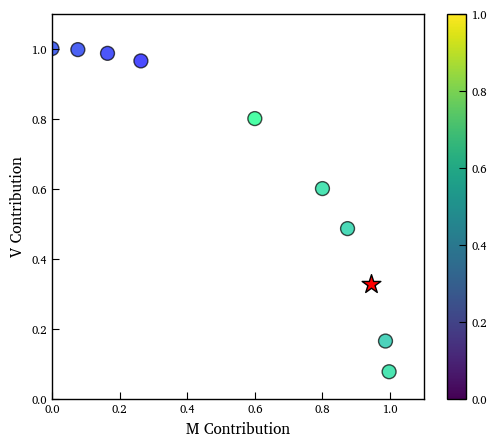

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M_contribution'], group_profiles['V_contribution'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M_contribution'], new_profile['V_contribution'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel('M Contribution')
plt.ylabel('V Contribution')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.colorbar()

plt.show()

In [24]:
current_id = len(df_full)

new_profile.index = [current_id]
new_profile['M_Rd'] = None
new_profile['V_Rd'] = None
new_profile['M'] = None
new_profile['V'] = None
new_profile['proz'] = None

This is the resulting profile. The geometric and material features are taken from the base profile (template), only the load combination is novel. 

In [25]:
new_profile

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEB100,100,100,6.0,10.0,2603.610658,903.610658,4495000,89910.0,104200,...,None,None,0.327068,0.945001,0.033482,0.435268,0.436554,0,0,NaN


Convert `M_contribution`and `V_contribution`to loads $M$ and $V$:

In [26]:
def get_MV(profile):
    Mplx = profile['Mpl_x']
    Mply = profile['Mpl_y']
    Vplx = profile['Vpl_x']
    Vply = profile['Vpl_y']
    V_cont = profile['V_contribution']
    M_cont = profile['M_contribution']

    ratio = V_cont / (M_cont +1e-12)
    Vmax = np.max([Vplx, Vply])
    Mmax = np.max([Mplx, Mply])
    Mnorm = Mmax / Mply
    Vnorm = Vmax / Vply
    
    M = Vnorm / (ratio + Vnorm / Mnorm)
    V = ratio * M

    profile['M'] = M*Mply
    profile['V'] = V*Vply

In [27]:
get_MV(new_profile)

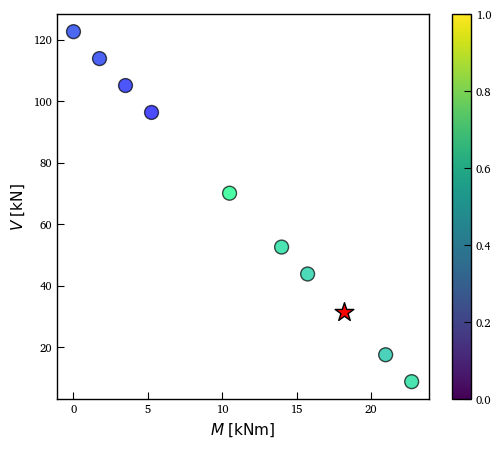

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M'], group_profiles['V'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M'], new_profile['V'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel(plot_params.feature_labels['M'])
plt.ylabel(plot_params.feature_labels['V'])

plt.colorbar()

plt.show()

### 3. Calculate Resistance with API

In [29]:
os.chdir(r"AL_API")
from API import IdeaConnectionClient

Absolute Paths are needed.

In [30]:
PATH = os.path.join(directory.root, "AL_API")
InputFileName = os.path.join(PATH,"Knee_widener_I_Output_red_Q4.parquet")

There are four idea templates. Depending on the existence of certain features, different templates have to be chosen. Depending on the lowest nonzero feature (see image), the according template is chosen.

<img src="templates.png" alt="image" width="600"/>

In [192]:
# All template names
ideatemplates_filenames = ['Corner.ideaCon',
                        'Corner_Stiffner.ideaCon',
                        'Corner_Stiff_Wid.ideaCon',
                        'Corner_Stiff2_Wid.ideaCon']

# Features that vary across templates
variable_features = ['t_stiffc',
                'h_wid',
                'b_wid',
                'd_wid',
                't_fwid',
                't_wwid',
                't_stiffb'
                ]

# How many variables each template has (e.g. Corner is the most simplest template and has 0 variable features)
existing_variable_features = {'Corner.ideaCon':0,
                              'Corner_Stiffner.ideaCon':1,
                              'Corner_Stiff_Wid.ideaCon':6,
                              'Corner_Stiff2_Wid.ideaCon':7}

existing_variable_features_indices = np.array(list(existing_variable_features.values()))

# Function to retrieve the ideal template based on the profile
def get_ideatemplate(profile):
    values = profile[variable_features].fillna(0).astype(float).values.flatten()
    nonzero_indices = np.nonzero(values)[0]
    highest_nonzero_index = 0 if len(nonzero_indices) == 0 else np.max(nonzero_indices) + 1
    ideatemplate_id = np.nanargmin(np.abs(existing_variable_features_indices - highest_nonzero_index))
    return ideatemplates_filenames[ideatemplate_id]

Find the template for the considered profile and open it in IdeaStatica.

In [32]:
inputs = new_profile.copy()
ideatemplate = get_ideatemplate(inputs)
IdeaName = os.path.join(PATH,ideatemplate)

conn = IdeaConnectionClient()
conn.open(IdeaName)

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner.ideaCon


### 4. Prepare

Adjust the feature labeling and the unit scaling to match with IdeaStatica.

In [33]:
i=inputs.index[0]  
params = {
    'Prof_c': inputs.at[i, 'Profile_x'], 'Prof_b': inputs.at[i, 'Profile_y'],
    'steel_grade': inputs.at[i, 'Steel grade_x'], 'gamma': inputs.at[i, 'Gamma'], 
    'h_wid': inputs.at[i, 'h_wid']/1000, 'b_wid': inputs.at[i, 'b_wid']/1000,
    'd_wid': inputs.at[i, 'd_wid']/1000, 't_fwid': inputs.at[i, 't_fwid']/1000,
    't_wwid': inputs.at[i, 't_wwid']/1000, 
    't_stiffc': inputs.at[i, 't_stiffc']/1000, 't_stiffb': inputs.at[i, 't_stiffb']/1000,
    'offset': inputs.at[i, 'Offset']/1000  
}

Load parameters into IdeaStatice to build the profile.

In [34]:
conn.update_params_by_name(params)
if not conn.params_valid():
    raise Exception("Parameters validation failed.")

#### 5. Define Loads

Functions to adjust loads incrementely up (underloaded) or down (overloaded).

In [35]:
def overloaded(calculated,conn,profiles,i):
    overload_counter=0
    while calculated == False:
        print('k =', overload_counter)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=0.9
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=0.9
        else:
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=0.9
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] ) 
        calculated = conn.calculate()
        overload_counter=(overload_counter+1)
        if overload_counter == 100:
            break
        
# In case of underload,, get in the loop and decrease the load:
def underloaded(applied_percentage,conn,profiles,i):
    underload_counter=0
    while applied_percentage == 1:
        print('j =', underload_counter)
        print('Applied percentage =',applied_percentage)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=1.1
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=1.1
        else:    
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=1.3
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] )    
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,profiles,i)
        
        # Get the applied loads:
        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']
        underload_counter=(underload_counter+1)

    return results, loads, applied_percentage

In [36]:
loads = conn.get_loads()

loads[0]['forcesOnSegments'][1]['my'] = int(inputs.at[i,'M']*1000)
loads[0]['forcesOnSegments'][1]['qz'] = int(inputs.at[i,'V']*1000)#!!!!

conn.set_loads(loads) 
print('M=',loads[0]['forcesOnSegments'][1]['my'] )
print('V=',loads[0]['forcesOnSegments'][1]['qz'] )            

M= 18191
V= 31522


In [37]:
new_profile['M'] = inputs['M'].values[0]
new_profile['V'] = inputs['V'].values[0]

### 6. Calculate

Calculate ...

In [38]:
calculated = conn.calculate()

if calculated == False:
    overloaded(calculated, new_profile, new_profile.index[0])

Get results:

In [39]:
results = conn.get_results()
loads = conn.get_loads()
applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
if applied_percentage == 1:
    underloaded(applied_percentage,new_profile,new_profile.index[0])

applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

outputs = inputs.copy()

outputs.at[i, 'proz'] = applied_percentage
outputs.at[i, 'M_Rd'] = applied_M/1000 # [kNm]
outputs.at[i, 'V_Rd'] = applied_V/1000 # [kN]

cost = results['costEstimationResults']['totalEstimatedCost']
outputs.at[i, 'cost'] = cost

Final profile with calculate moment and shear resistance.

In [40]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEB100,100,100,6.0,10.0,2603.610658,903.610658,4495000,89910.0,104200,...,10.09032,17.484859,0.327068,0.945001,0.033482,0.435268,0.436554,0,0,5.499936


Calculate the target value from the resulting moment and shear resistance.

In [41]:
def calculate_target_from_Rd(profile):
    profile['V_norm'] = abs(profile['V_Rd'] / profile['Vpl_y'])
    profile['M_norm'] = abs(profile['M_Rd'] / profile['Mpl_y'])
    profile['target'] = (profile['V_norm']**2 + profile['M_norm']**2)**0.5

In [42]:
calculate_target_from_Rd(outputs)

In [43]:
conn.close()

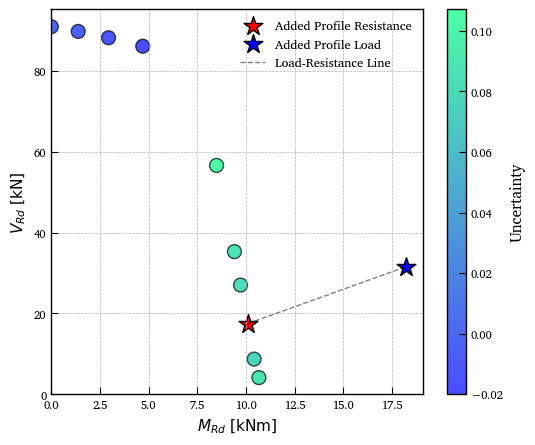

In [44]:
fig, ax = plt.subplots(figsize=(6,5))

sc = plt.scatter(df_full.loc[most_uncertain_group_ids]['M_Rd'].values,
            df_full.loc[most_uncertain_group_ids]['V_Rd'].values,
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(outputs['M_Rd'].values,
            outputs['V_Rd'].values,
            c='red', s=200, edgecolor='black', label='Added Profile Resistance', marker='*')

plt.scatter(outputs['M'],
            outputs['V'],
            c='blue', s=200, edgecolor='black', label='Added Profile Load', marker='*')

plt.plot((outputs['M_Rd'].values, outputs['M'].values),(outputs['V_Rd'].values, outputs['V'].values),
         color='black', linestyle='--', linewidth=1, alpha=0.5, label='Load-Resistance Line')

plt.xlabel(plot_params.feature_labels['M_Rd'])
plt.ylabel(plot_params.feature_labels['V_Rd'])

plt.legend()
plt.colorbar(sc,label='Uncertainty')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Analysis of Results

### Model Performance

In [354]:
ids_added = np.array(list(df_AL.loc[len(df):].index))
ids_before = np.array(list(df_full.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds_before, _ = model.predict(df_AL)
y_truth_before = df_AL['target'].values

# Get Predictions after AL
y_preds_after, _ = model_AL.predict(df_AL)
y_truth_after = df_AL['target'].values

y_preds_after = y_preds_after.numpy().flatten()
y_preds_before = y_preds_before.numpy().flatten()

# Calculate relative error
error_before = np.abs((y_preds_before - y_truth_before) / y_truth_before+1e-8)
error_after = np.abs((y_preds_after[ids_before] - y_truth_after[ids_before]) / y_truth_after[ids_before]+1e-8)
error_added = np.abs((y_preds_after[ids_added] - y_truth_after[ids_added]) / y_truth_after[ids_added]+1e-8)

In [60]:
metrics_before = model.get_metrics()
metrics_after = model_AL.get_metrics()

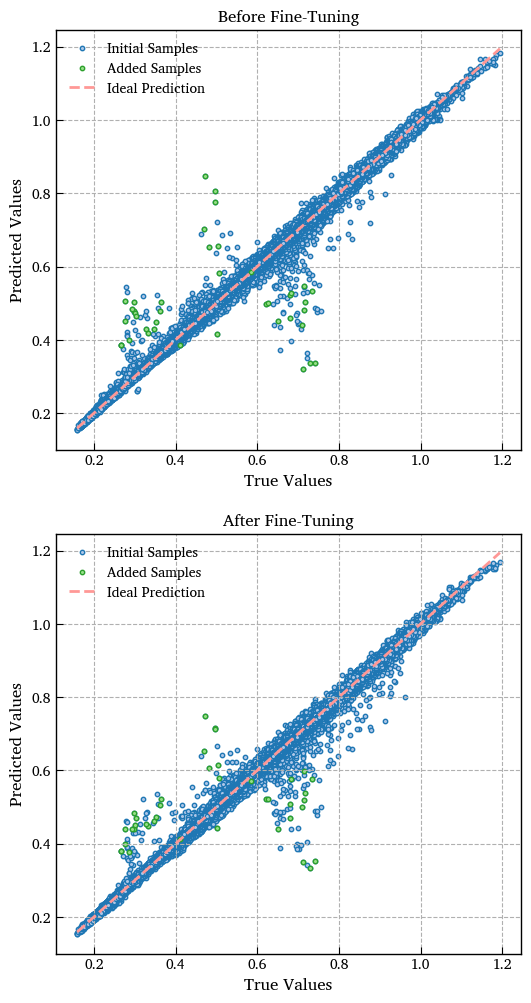

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

axs[0].scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=2
            )

axs[0].scatter(y_truth_before[ids_added], y_preds_before[ids_added],
               label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

axs[0].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[0].grid(True, linestyle='--', zorder=0)

axs[1].scatter(y_truth_after, y_preds_after, 
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10
            )

axs[1].scatter(y_truth_after[ids_added], y_preds_after[ids_added],
            label='Added Samples', 
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

axs[1].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[1].grid(True, linestyle='--', zorder=0)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Before Fine-Tuning')
axs[1].set_title('After Fine-Tuning')

axs[0].set_xlabel('True Values')
axs[1].set_xlabel('True Values')

axs[0].set_ylabel('Predicted Values')
axs[1].set_ylabel('Predicted Values')

plt.show()

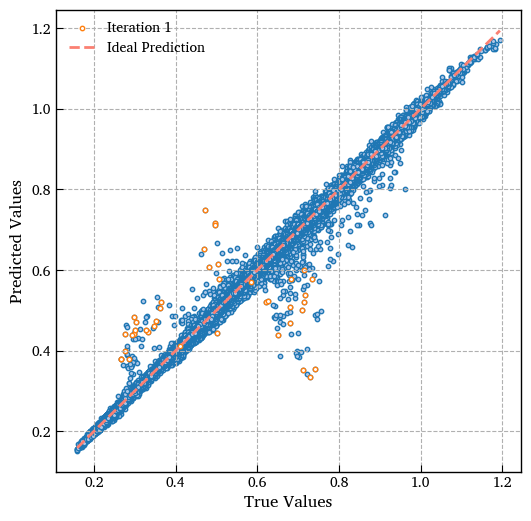

In [352]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_truth_after, y_preds_after, 
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            alpha=1.0
            )

for i in range(iterations):
    ax.scatter(y_truth_after[df_AL['iteration'] == i+1],
                y_preds_after[df_AL['iteration'] == i+1],
                label=f'Iteration {i+1}',
                facecolor='white',
                edgecolor=plot_params.morecolors[2*(i+1)],
                s=10,
                alpha=1.0
                )

ax.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

ax.grid(True, linestyle='--', zorder=0)
ax.legend()
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

plt.show()

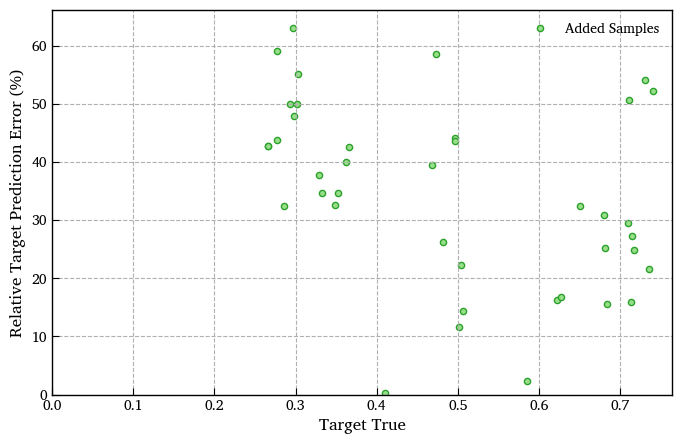

In [359]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(df_added['target'],error_added*100,
            label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=20
            )

plt.xlabel('Target True')
plt.ylabel('Relative Target Prediction Error (%)')
plt.legend()

plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True, linestyle='--', zorder=0)

plt.show()

In [46]:
worst_samples = np.argsort(error_added)[-10:]

df_added.iloc[worst_samples].sort_values(by='target', ascending=False)

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,Unnamed: 0,base_sample_id,iteration,template
720381,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.013098,0.018529,0.022691,0,1,31.483132,720381.0,161754.0,2.0,Corner.ideaCon
720379,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.015414,0.016334,0.022458,0,1,31.483132,720379.0,161754.0,2.0,Corner.ideaCon
720351,HEA200,190,200,6.5,10.0,5383.123980,1808.123980,36920000,388600.0,429500,...,0.012158,0.018857,0.022436,0,1,6.851456,720351.0,153057.0,2.0,Corner.ideaCon
717762,HEA220,210,220,7.0,11.0,6434.123980,2067.123980,54100000,515200.0,568500,...,0.012079,0.018354,0.021973,1,1,9.087990,717762.0,246960.0,2.0,Corner.ideaCon
720384,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.010104,0.015192,0.018245,1,1,43.829408,720384.0,401774.0,2.0,Corner.ideaCon
720375,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.010478,0.014823,0.018153,0,1,31.483132,720375.0,162325.0,2.0,Corner.ideaCon
717729,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.010273,0.014904,0.018101,0,1,38.110780,717729.0,163392.0,2.0,Corner.ideaCon
714695,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,714695.0,401774.0,1.0,Corner.ideaCon
720382,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,720382.0,401774.0,2.0,Corner.ideaCon
717727,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.012089,0.013138,0.017854,0,1,38.110780,717727.0,163392.0,2.0,Corner.ideaCon


### Loss Progression

Training and Validation Loss Spike

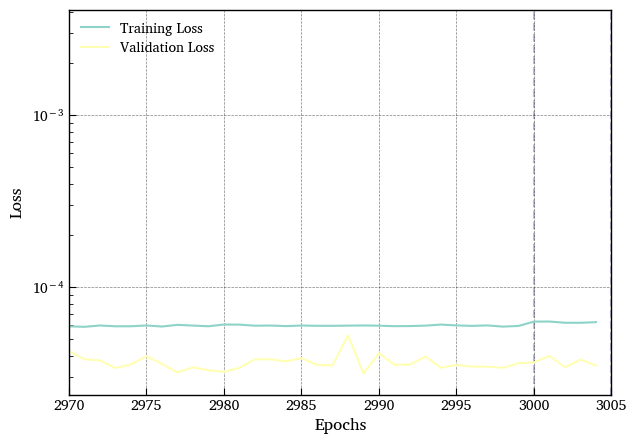

In [360]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model_AL.train_losses['total'], label='Training Loss', c=plot_params.colors[0],zorder=2)
plt.plot(model_AL.val_losses['total'], label='Validation Loss', c=plot_params.colors[1],zorder=2)

for i in range(iterations):
    iterations_start = model_AL.config['epochs'] + i * epochs_per_iter
    iterations_end = iterations_start + epochs_per_iter
    plt.axvline(x=iterations_start, color=plot_params.colors[2], linestyle='--',zorder=0)
    plt.axvline(x=iterations_end, color=plot_params.colors[2], linestyle='--',zorder=0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0.99*model.config['epochs'],model.config['epochs']+iterations*epochs_per_iter])
plt.yscale('log')
plt.legend()

### Features of Data Added

In [69]:
df_added = df_AL.loc[ids_added].copy()

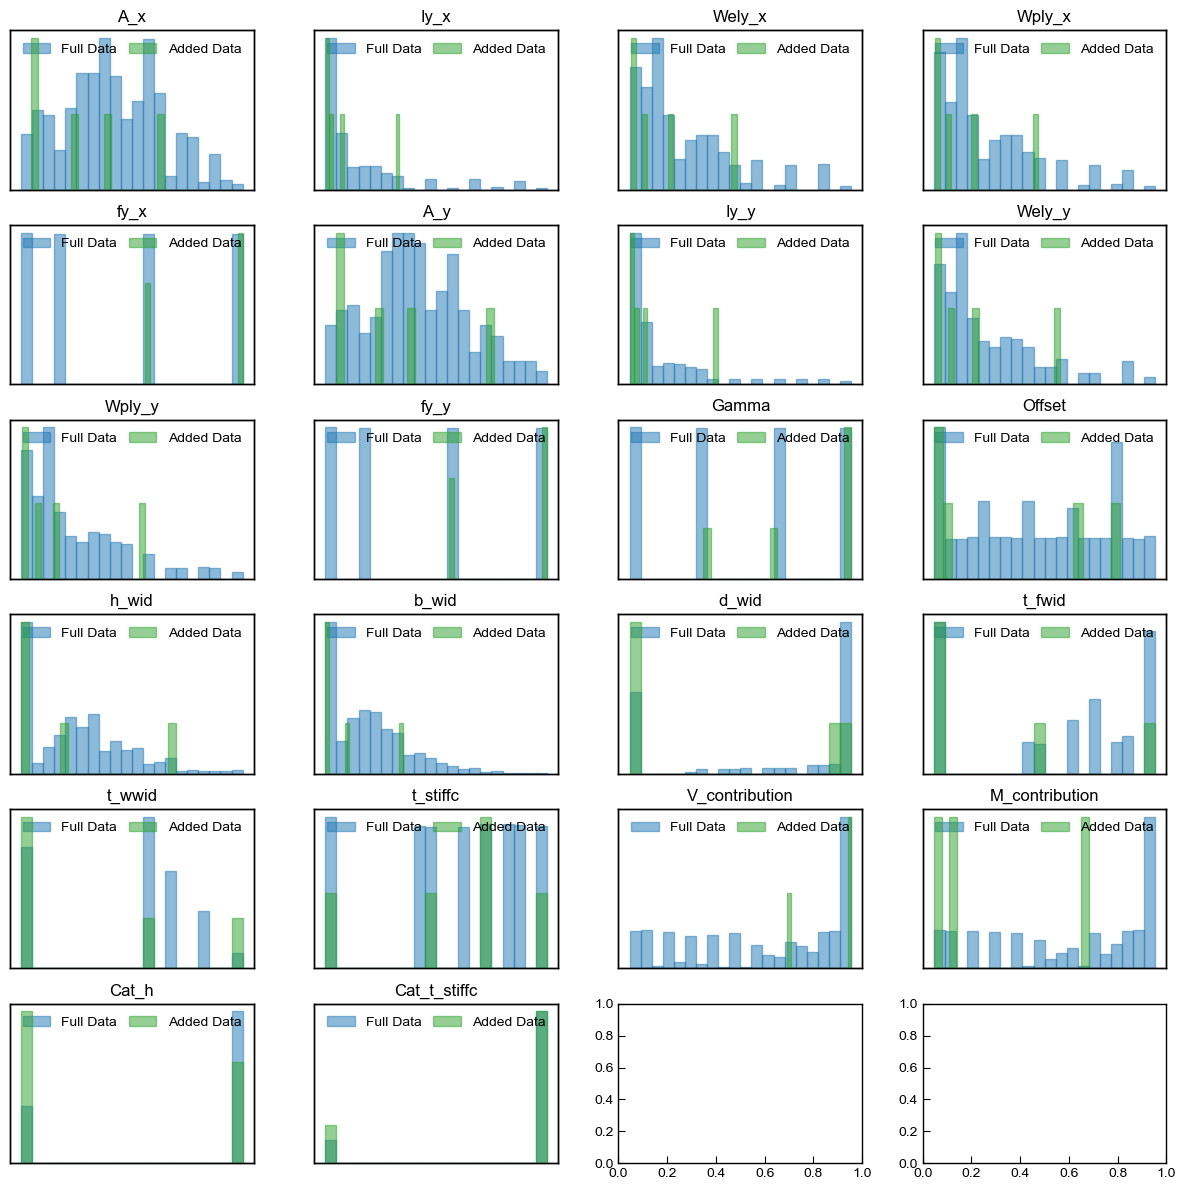

In [182]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_full[feature].values, bins=20, 
            edgecolor=plot_params.colors[0], 
            facecolor=plot_params.colors[0],
            alpha=0.5, label='Full Data')
    ax2.hist(df_added[feature].values, bins=20, 
             edgecolor=plot_params.colors[2],
             facecolor=plot_params.colors[2],
             alpha=0.5, label='Added Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Check added M-V location

In [389]:
def calculate_error(curve, points):
    curve = np.asarray(curve, dtype=float)
    points = np.atleast_2d(np.asarray(points, dtype=float))

    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    # Extracts the starting point of each segment — these are the anchors for the line segments.
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    # Scalar projection
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

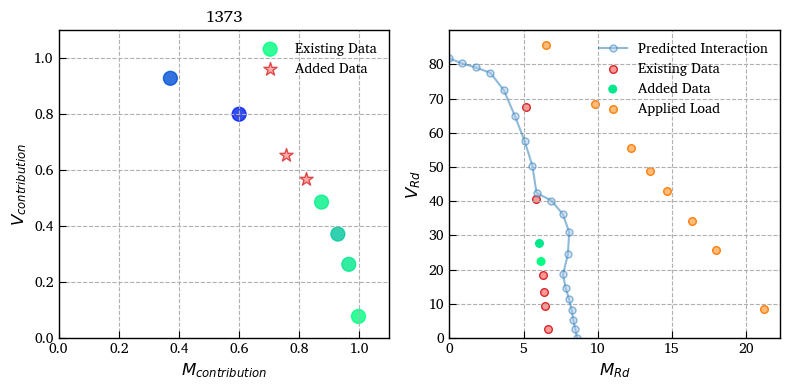

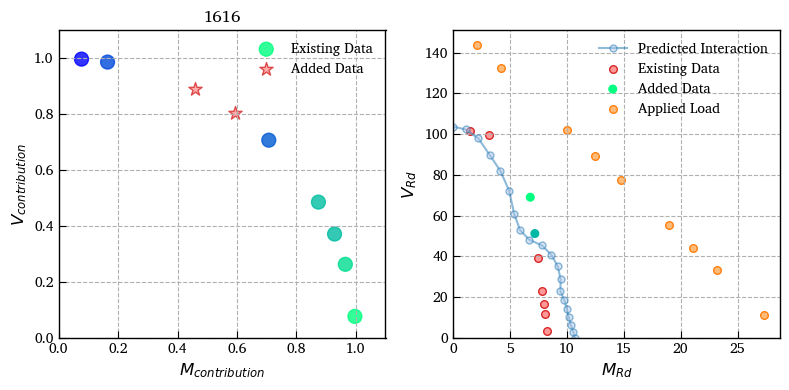

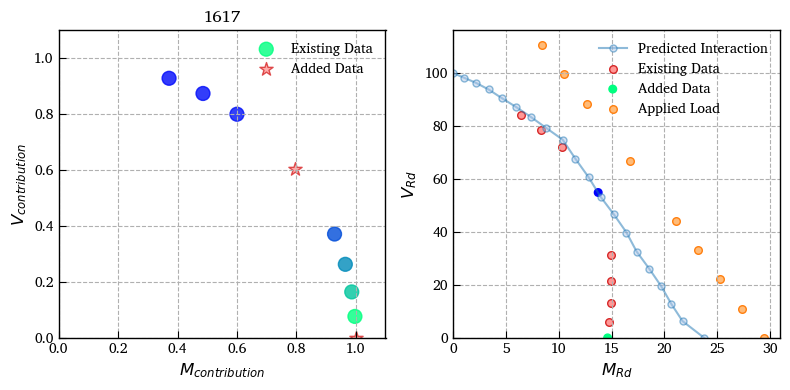

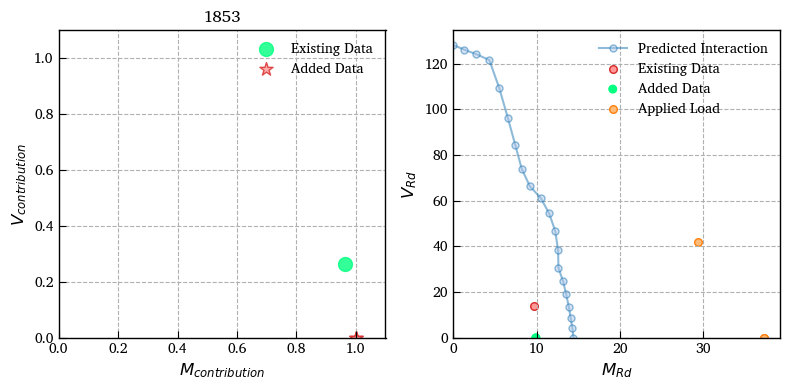

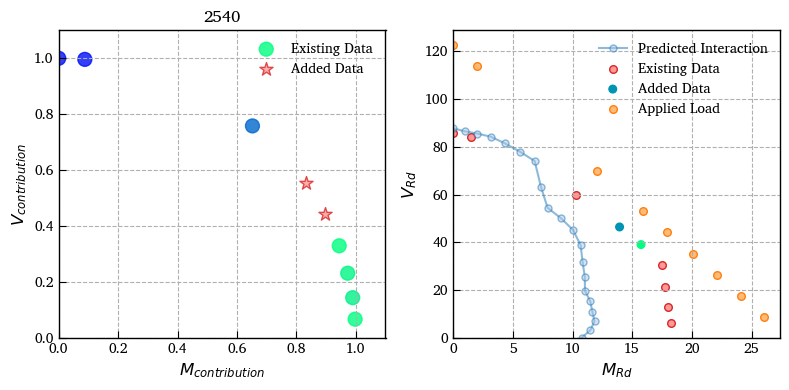

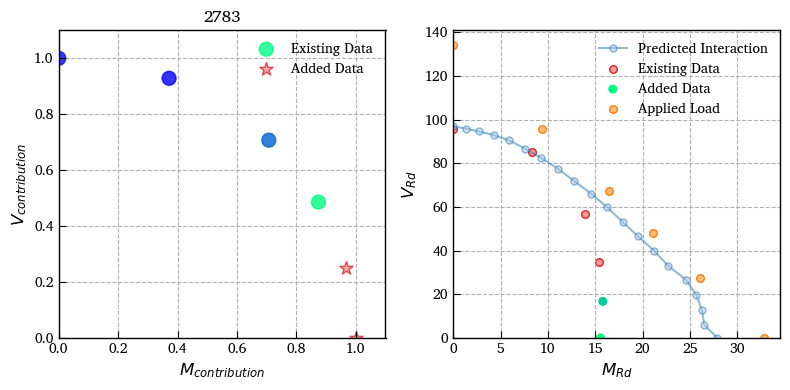

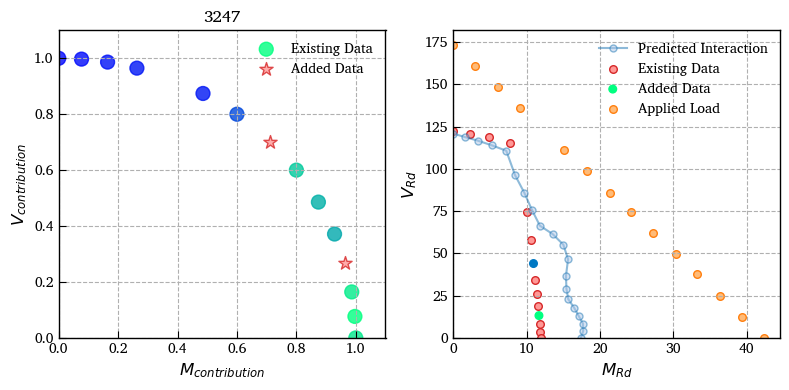

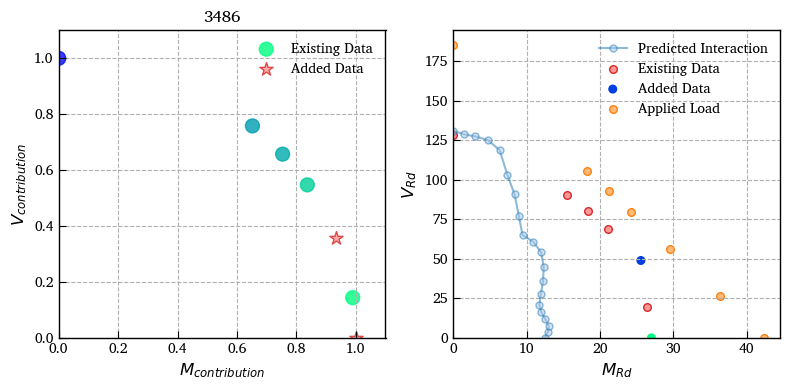

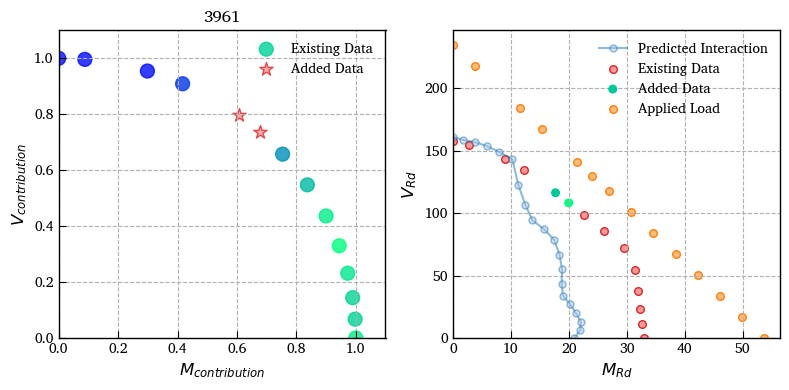

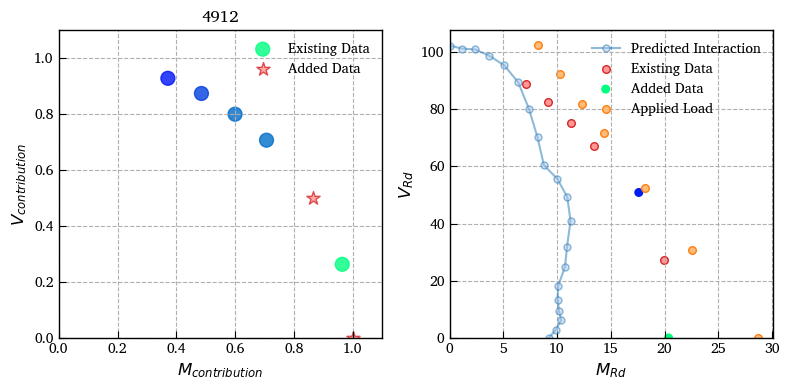

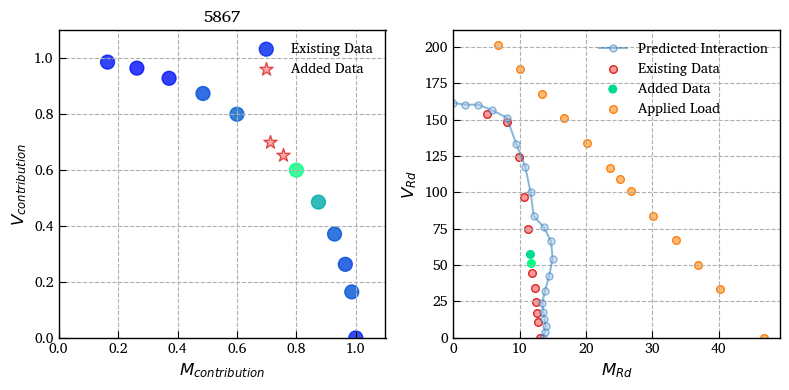

In [392]:
n_before = len(df_full)
counter = 0
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 10:
            break
        else:
            counter += 1

        M_contribution = df_AL.loc[group]['M_contribution'].values
        V_contribution = df_AL.loc[group]['V_contribution'].values
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths

        fig, axs = plt.subplots(1,2,figsize=(8, 4))
        ax = axs[0]
        ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
                    label='Existing Data',
                    c=np.abs(rel_error[np.array(group)[mask_before]]),
                    cmap='winter',
                    vmin=0,
                    alpha=0.8,
                    s=100)
        ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
                    label='Added Data',
                    marker='*',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=0.8,
                    s=100)
        ax.set_xlabel(r'$M_{contribution}$')
        ax.set_ylabel(r'$V_{contribution}$')
        ax.grid(True, linestyle='--', zorder=0)
        ax.set_title(group_id)
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.legend()

        ax = axs[1]
        ax.plot(M_Rd_pred, V_Rd_pred, 
                    label='Predicted Interaction',
                    marker='o',
                    c=plot_params.morecolors[0],
                    markerfacecolor=plot_params.morecolors[1],
                    markeredgecolor=plot_params.morecolors[0],
                    alpha=0.5,
                    markersize=5)

        ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
                    label='Existing Data',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
                    label='Added Data',
                    c=rel_deviation,
                    cmap='winter',
                    vmin=0,
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M'].values, df_group['V'].values,
                    label='Applied Load',
                    facecolor=plot_params.morecolors[3],
                    edgecolor=plot_params.morecolors[2],
                    s=30)

        ax.set_xlabel(r'$M_{Rd}$')
        ax.set_ylabel(r'$V_{Rd}$')
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle='--', zorder=0)
        ax.legend()

        plt.tight_layout()
        plt.show()

### Analyse Errors

In [393]:
n_before = len(df_full)
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths
        df_AL.loc[np.array(group)[mask_added], 'rel_deviation'] = rel_deviation

In [394]:
df_error = df_AL[~np.isnan(df_AL['rel_deviation'])].copy()

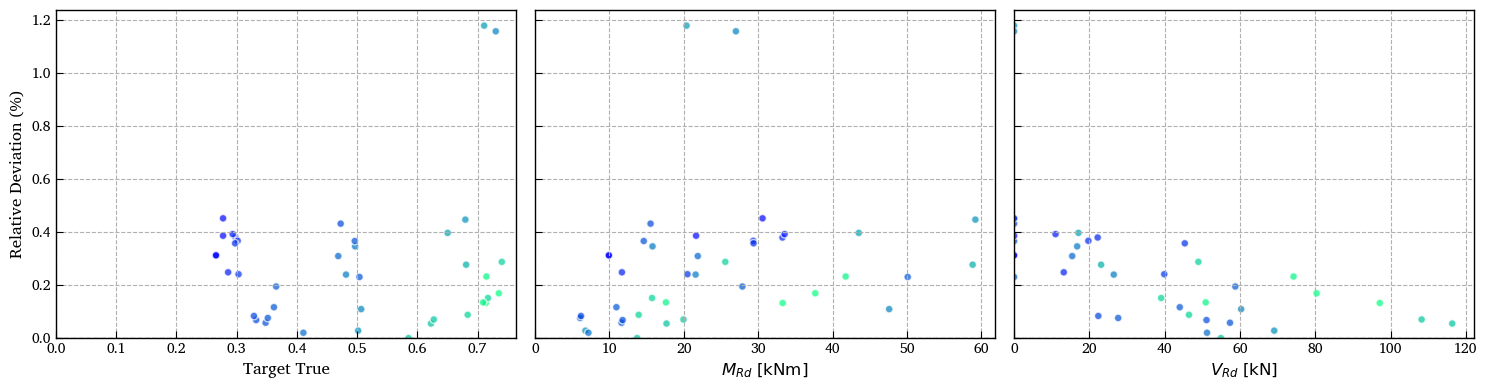

In [395]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['target'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Target True')
axs[0].set_ylabel('Relative Deviation (%)')

axs[1].scatter(df_error['M_Rd'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel(plot_params.feature_labels['M_Rd'])

axs[2].scatter(df_error['V_Rd'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['V_Rd'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

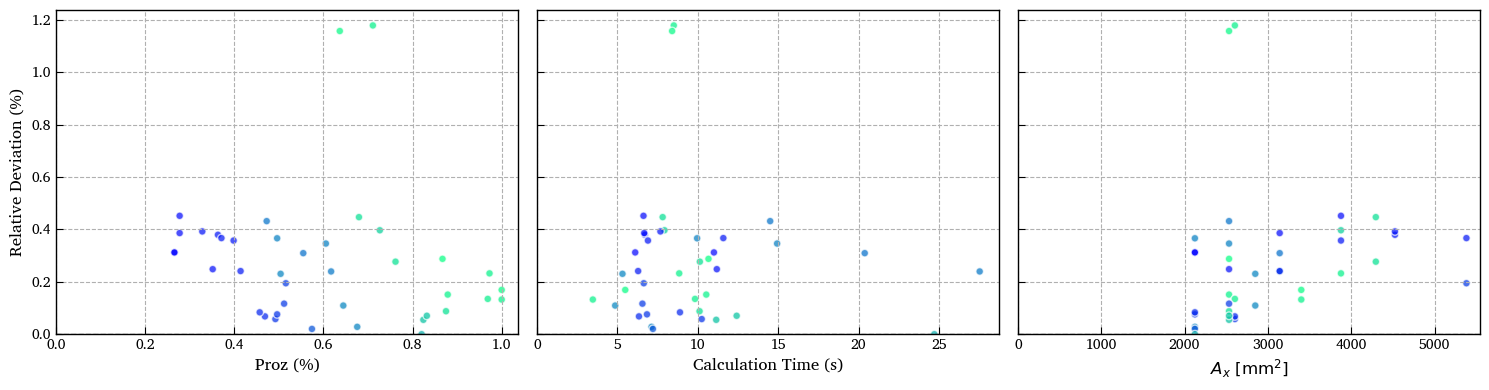

In [396]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['proz'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Proz (%)')
axs[0].set_ylabel('Relative Deviation (%)')

axs[1].scatter(df_error['calculation_time'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel('Calculation Time (s)')

axs[2].scatter(df_error['A_x'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['A_x'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

In [399]:
import seaborn as sns

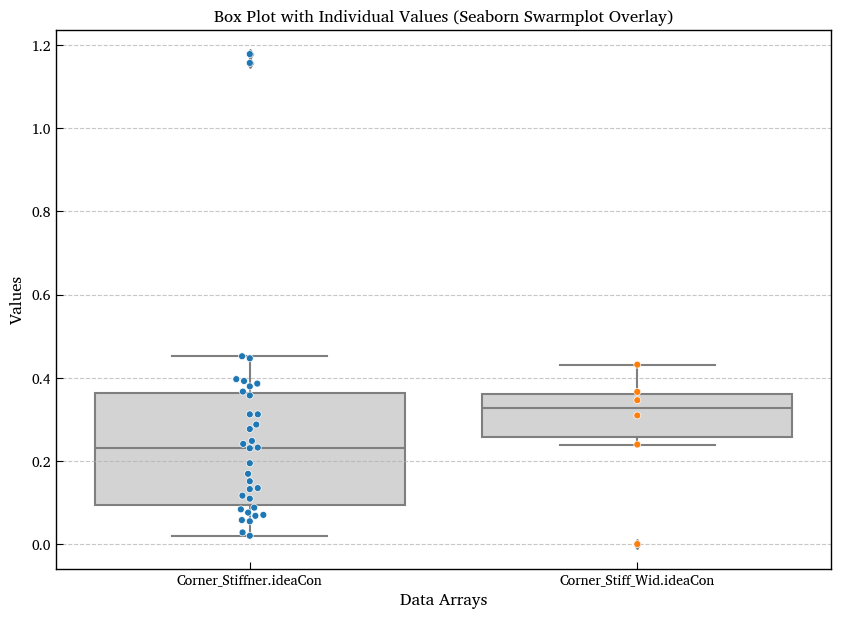

In [400]:
df_long = pd.DataFrame({
    'Value': np.concatenate([df_error[df_error['template'] == ideatemplates_filenames[0]]['rel_deviation'].values, 
                             df_error[df_error['template'] == ideatemplates_filenames[1]]['rel_deviation'].values,
                             df_error[df_error['template'] == ideatemplates_filenames[2]]['rel_deviation'].values,
                             df_error[df_error['template'] == ideatemplates_filenames[3]]['rel_deviation'].values]),
    'Array_Name': [ideatemplates_filenames[0]] * len(df_error[df_error['template'] == ideatemplates_filenames[0]]['rel_deviation'].values) +
                  [ideatemplates_filenames[1]] * len(df_error[df_error['template'] == ideatemplates_filenames[1]]['rel_deviation'].values) +
                  [ideatemplates_filenames[2]] * len(df_error[df_error['template'] == ideatemplates_filenames[2]]['rel_deviation'].values) +
                  [ideatemplates_filenames[3]] * len(df_error[df_error['template'] == ideatemplates_filenames[3]]['rel_deviation'].values)
})

# 3. Create the figure and axes
plt.figure(figsize=(10, 7)) # Adjust figure size as needed

sns.boxplot(x='Array_Name', y='Value', data=df_long, ax=plt.gca(), color='lightgray')

sns.swarmplot(x='Array_Name', y='Value', data=df_long, ax=plt.gca(),
              palette='tab10', edgecolor='white', linewidth=0.5, size=5)

# 6. Add labels and title for better understanding
plt.title('Box Plot with Individual Values (Seaborn Swarmplot Overlay)')
plt.ylabel('Values')
plt.xlabel('Data Arrays')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability

# Display the plot
plt.show()

### Correlations

In [401]:
correlations = df_AL[~np.isnan(df_AL['rel_deviation'])].select_dtypes(include='number').corr()['rel_deviation'].sort_values(ascending=False)
print(correlations)

rel_deviation       1.000000
M_contribution      0.606728
M                   0.312419
tw_y                0.178642
A_y                 0.172251
A_x                 0.170334
tf_y                0.155726
tw_x                0.142406
cost                0.141078
Wely_x              0.137848
Wely_y              0.131734
Av_y                0.129076
Av_x                0.123333
tf_x                0.120934
Mpl_x               0.116901
Mpl_y               0.112144
Vpl_y               0.040300
Vpl_x               0.037318
h_wid               0.024464
base_sample_id      0.010584
b_wid               0.002735
calculation_time   -0.060313
tau_x              -0.108386
tau_y              -0.108386
V                  -0.600314
V_contribution     -0.697079
Gamma                    NaN
Offset                   NaN
Offset_Idea              NaN
iteration                NaN
Name: rel_deviation, dtype: float64


#### Uncertainty

In [402]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_added, num_samples=200)
uncertainty_added = mcd_std.flatten() / mcd_mean.flatten()

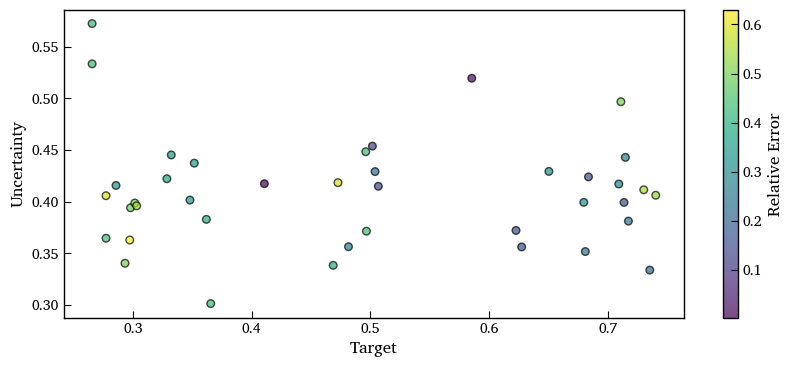

In [403]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(df_added['target'], uncertainty_added, label='Added Data',
            c=error_added, cmap='viridis', edgecolor='black', s=30, alpha=0.7)

plt.colorbar(label='Relative Error')
plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

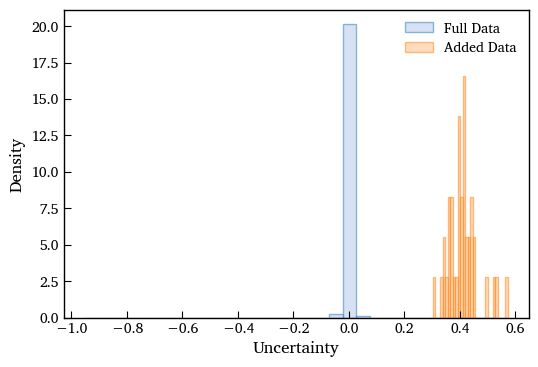

In [404]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=30,
         edgecolor=plot_params.morecolors[0], 
         facecolor=plot_params.morecolors[1], 
         alpha=0.5, label='Full Data',
         density=True)

plt.hist(uncertainty_added, bins=30, 
         edgecolor=plot_params.morecolors[2], 
         facecolor=plot_params.morecolors[3], 
         alpha=0.5, label='Added Data',
         density=True)

plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')

plt.show()

## Global Active Learning

## Preprocessing

### Get necessary variables

Files needed:
- `Saved Variables\hypercubemap.npy` generated by `Feasible_Hypercubemap_Generation`
- `Saved Variables\hypercube_features.json` generated by `Feasible_Hypercubemap_Generation`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth` generated by `DNN_FullModel.ipynb`

In [45]:
directory.reset_root()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


#### Load Hypercubemap

In [42]:
hypercubemap = np.load(r"Saved Variables\hypercubemap.npy")
with open("Saved Variables\hypercube_features.json", "rb") as file: 
        hypercube_features = pickle.load(file)

#### Load Model

In [43]:
model = DNN()

model_name = "DNN_Model_Full_V3"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features


### Define Functions 

Finds the $n$-dimensional coordinates in the hypercubemap with $m$ bins for a given datapoint.

In [44]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

Calculates maximum neighbouring distance over all dimensions and the normalized distance to the next feasible hypercube.

In [45]:
def check_feasibility(datapoint, hypercubemap, bounds, m):
    bin_indices = find_bins(datapoint, bounds, m)

    if bin_indices is None:
        return 'Datapoint is out of bounds'
    
    closest_index = np.argmin(np.sum((hypercubemap - bin_indices) ** 2, axis=1))
    closest_bin = hypercubemap[closest_index]
    error = np.abs(closest_bin - bin_indices)

    feasibilty_degree = np.max(error)

    return feasibilty_degree, np.sum(error)/len(error)

Define the upper and lower bounds of the data and the width of the bins for each dimension.

In [46]:
bounds = np.array([df_full[hypercube_features].min(), df_full[hypercube_features].max()]).T
m = np.max(hypercubemap)
lower_bounds = bounds[:, 0]
bin_widths = (bounds[:, 1] - bounds[:, 0]) / m

Function to sample a datapoint, given a hypercube. Randomly samples a value for each dimension according to a uniform distribution $\mathcal{U}(\mathrm{lower bound}, \mathrm{upper bound})$.

In [47]:
def sample_from_bins(bounds, m, map):
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    bin_widths = (upper_bounds - lower_bounds) / m

    bin_starts = lower_bounds + bin_widths * map
    bin_ends = bin_starts + bin_widths

    return np.random.uniform(bin_starts, bin_ends)

Define from what ratio of the Hypercubemap should be sampled from:

In [48]:
ratio = 1.0 # of the hypercube map to sample

n_samples = int(ratio * len(hypercubemap))
print(f"Sampling {n_samples} samples from the hypercube map.")

Sampling 115352 samples from the hypercube map.


## Sample

In [49]:
n_most_uncertain = 10
loads_per_curve = 5

Select random hypercubes (according to defined ratio `xx%`) and sample a datapoint in each selected hypercube.

In [50]:
sampling_hypercube_ids = random.sample(range(len(hypercubemap)),k=n_samples)
hypercube_samples = np.zeros((n_samples, len(hypercube_features)))

for hypercube_id in sampling_hypercube_ids:
    sampled_point = sample_from_bins(bounds, m, hypercubemap[hypercube_id])
    
    hypercube_samples[hypercube_id] = sampled_point

Define how many load combinations should be considered per sample:

In [51]:
loads_per_curve = loads_per_curve

Convert the samples to a DataFrame:

In [52]:
df_template = pd.DataFrame(columns=df_full.columns)
df_template = df_template.reindex(range(n_samples * loads_per_curve))

df_hypercube_samples_unique = pd.DataFrame(columns=df_full.columns)
df_hypercube_samples_unique = df_template.reindex(range(n_samples))
df_hypercube_samples_unique[hypercube_features] = hypercube_samples

Add the loads by spreading them equally over the first quadrant. 

In [53]:
df_hypercube_samples = df_template.copy()

df_hypercube_samples[hypercube_features] = np.repeat(hypercube_samples, loads_per_curve, axis=0)

theta = np.linspace(0, np.pi/2, loads_per_curve)

M_contributions = np.cos(theta).round(4)
V_contributions = np.sin(theta).round(4)

df_hypercube_samples['M_contribution'] = np.tile(M_contributions, n_samples)
df_hypercube_samples['V_contribution'] = np.tile(V_contributions, n_samples)

In [54]:
df_hypercube_samples['t_stiffb'] = np.zeros(n_samples * loads_per_curve)

In [55]:
df_hypercube_samples[model.features]

,A_x,Iy_x,Wely_x,Wply_x,fy_x,A_y,Iy_y,Wely_y,Wply_y,fy_y,Gamma,Offset,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffc,V_contribution,M_contribution
0,5940.779284,7.147523e+08,1.085273e+06,1.769438e+06,244.983319,6103.564029,1.253156e+07,3.169149e+05,3.328949e+04,263.172389,0.011950,24.274990,84.665398,149.627028,32.499359,1.307967,0.248102,0.203336,0.0000,1.0000
1,5940.779284,7.147523e+08,1.085273e+06,1.769438e+06,244.983319,6103.564029,1.253156e+07,3.169149e+05,3.328949e+04,263.172389,0.011950,24.274990,84.665398,149.627028,32.499359,1.307967,0.248102,0.203336,0.3827,0.9239
2,5940.779284,7.147523e+08,1.085273e+06,1.769438e+06,244.983319,6103.564029,1.253156e+07,3.169149e+05,3.328949e+04,263.172389,0.011950,24.274990,84.665398,149.627028,32.499359,1.307967,0.248102,0.203336,0.7071,0.7071
3,5940.779284,7.147523e+08,1.085273e+06,1.769438e+06,244.983319,6103.564029,1.253156e+07,3.169149e+05,3.328949e+04,263.172389,0.011950,24.274990,84.665398,149.627028,32.499359,1.307967,0.248102,0.203336,0.9239,0.3827
4,5940.779284,7.147523e+08,1.085273e+06,1.769438e+06,244.983319,6103.564029,1.253156e+07,3.169149e+05,3.328949e+04,263.172389,0.011950,24.274990,84.665398,149.627028,32.499359,1.307967,0.248102,0.203336,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576755,42337.444480,6.811997e+09,1.452272e+07,1.670943e+07,474.187319,43596.376275,6.923632e+09,1.399449e+07,1.537049e+07,473.901251,0.890192,262.183081,57.303249,29.632897,16.622328,1.210006,0.365279,27.257871,0.0000,1.0000
576756,42337.444480,6.811997e+09,1.452272e+07,1.670943e+07,474.187319,43596.376275,6.923632e+09,1.399449e+07,1.537049e+07,473.901251,0.890192,262.183081,57.303249,29.632897,16.622328,1.210006,0.365279,27.257871,0.3827,0.9239
576757,42337.444480,6.811997e+09,1.452272e+07,1.670943e+07,474.187319,43596.376275,6.923632e+09,1.399449e+07,1.537049e+07,473.901251,0.890192,262.183081,57.303249,29.632897,16.622328,1.210006,0.365279,27.257871,0.7071,0.7071
576758,42337.444480,6.811997e+09,1.452272e+07,1.670943e+07,474.187319,43596.376275,6.923632e+09,1.399449e+07,1.537049e+07,473.901251,0.890192,262.183081,57.303249,29.632897,16.622328,1.210006,0.365279,27.257871,0.9239,0.3827


Get Uncertainty and predicted Target of samples:

In [56]:
mcd_mean_hypercube, mcd_std_hypercube, _ = model.mc_dropout_uncertainty(df_hypercube_samples, num_samples=50)
uncertainty_hypercube = mcd_std_hypercube / mcd_mean_hypercube

y_preds_hypercube, _ = model.predict(df_hypercube_samples)
y_preds_hypercube = y_preds_hypercube.numpy().flatten()

In [57]:
for feature in model.features:
    if feature not in hypercube_features:
        print(feature)

V_contribution
M_contribution


#### Visualize uncertainty across different dimensions

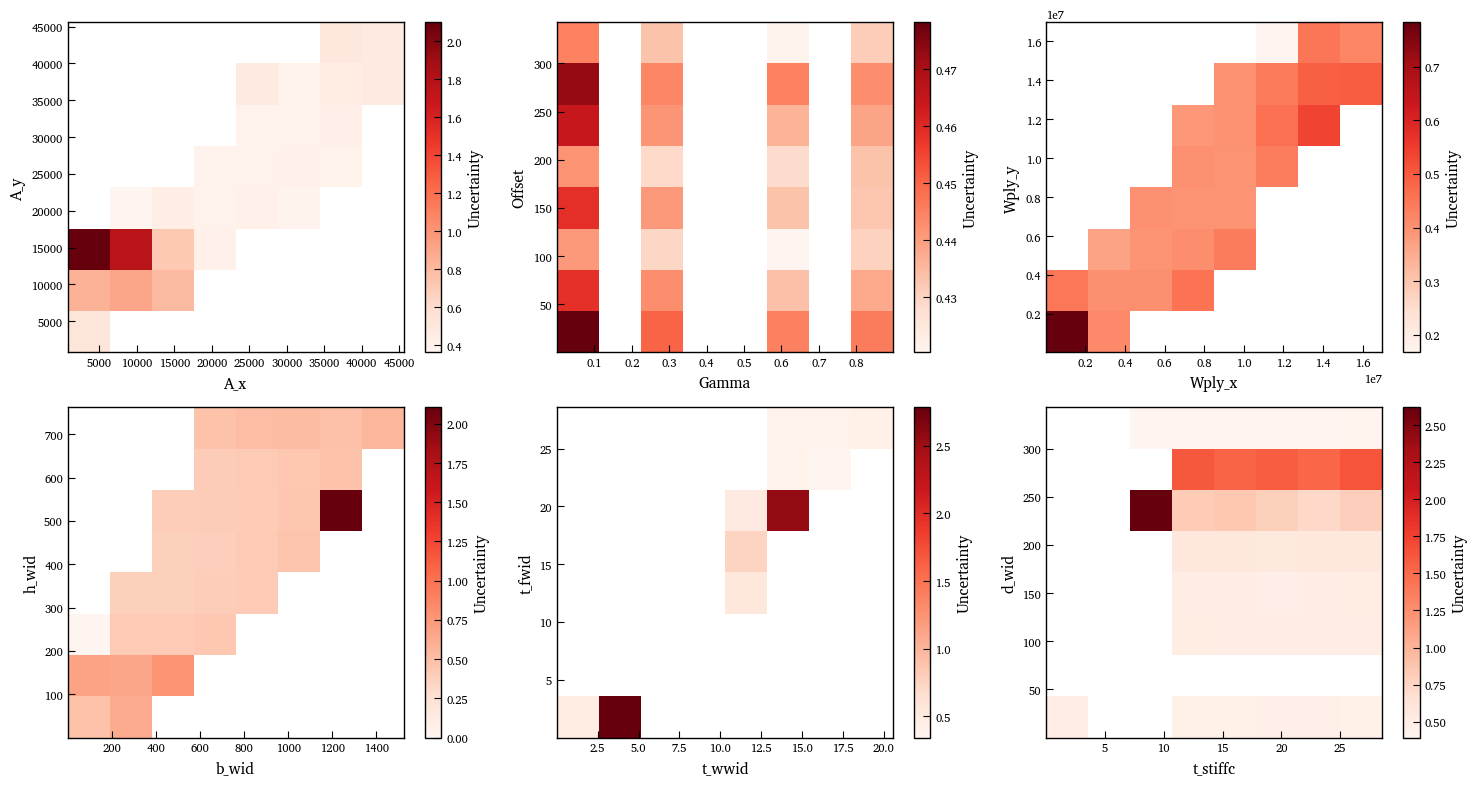

In [ ]:
grid_x, grid_y = m+1, m+1

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i,(x_feature,y_feature) in enumerate(zip(['A_x','Gamma','Wply_x','b_wid','t_wwid','t_stiffc'],['A_y','Offset','Wply_y','h_wid','t_fwid','d_wid'])):
    
    x = df_hypercube_samples[x_feature].values
    y = df_hypercube_samples[y_feature].values
    c = np.clip(uncertainty_hypercube, 0, None).flatten()

    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, c, statistic='median', bins=[grid_x, grid_y]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, 
                    (y_edges[:-1] + y_edges[1:]) / 2)

    pcm = axs[int(i/3),i%3].pcolormesh(X, Y, stat.T, cmap='Reds', shading='auto')

    fig.colorbar(pcm, ax=axs[int(i/3),i%3], label="Uncertainty")

    axs[int(i/3),i%3].set_xlabel(x_feature)
    axs[int(i/3),i%3].set_ylabel(y_feature)


plt.tight_layout()
plt.show()

### Identify critical Data

Identify and select the n most uncertain samples.

In [115]:
n_most_uncertain = n_most_uncertain

In [116]:
most_uncertain_hypercubes = np.argsort(uncertainty_hypercube.flatten())[-n_most_uncertain:]

index_mapping = np.repeat(np.arange(n_samples), loads_per_curve,axis=0)

print(f"{len(np.unique(index_mapping[most_uncertain_hypercubes]))} of {len(most_uncertain_hypercubes)} are unique hypercubes.")

10 of 10 are unique hypercubes.


In [117]:
df_samples = df_hypercube_samples.loc[most_uncertain_hypercubes].copy()

In [118]:
df_samples

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
189671,NaN,395.230325,309.572150,8.901534,15.949620,13309.351041,5443.292879,7.834249e+08,3.790542e+05,6.468308e+04,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN
152277,NaN,322.172248,310.394314,12.222661,18.894448,12112.549919,5375.554305,8.439322e+08,2.773558e+06,5.019127e+05,...,NaN,NaN,0.7071,0.7071,NaN,NaN,NaN,NaN,NaN,NaN
204192,NaN,375.986978,331.377208,11.848080,14.277424,13767.771437,3380.216960,1.188897e+08,2.148499e+06,3.424827e+05,...,NaN,NaN,0.7071,0.7071,NaN,NaN,NaN,NaN,NaN,NaN
37304,NaN,144.153798,169.339924,8.479221,17.902325,3628.082934,2794.546655,7.410401e+08,1.080287e+06,1.837650e+05,...,NaN,NaN,1.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
120349,NaN,242.353497,327.389791,9.694626,15.083488,16520.452412,3997.774275,7.687845e+08,4.471084e+05,1.079561e+05,...,NaN,NaN,1.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
184493,NaN,473.816601,330.315267,8.994562,15.799563,15832.675975,6233.277209,3.398946e+08,9.646685e+04,2.398551e+04,...,NaN,NaN,0.9239,0.3827,NaN,NaN,NaN,NaN,NaN,NaN
114156,NaN,224.914837,307.357120,9.602786,15.074927,6848.249435,5564.138964,8.410883e+08,1.357819e+06,6.861331e+05,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN
135847,NaN,230.359519,303.468676,8.374097,15.627287,17247.150160,3750.985008,8.462211e+08,1.713414e+06,1.160670e+06,...,NaN,NaN,0.7071,0.7071,NaN,NaN,NaN,NaN,NaN,NaN
31501,NaN,168.011658,162.717376,7.651075,9.237514,4056.722301,693.573517,6.198117e+08,8.053140e+04,1.225396e+05,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN
166696,NaN,260.442005,303.115725,11.550444,21.762353,12264.200198,5725.440499,8.215205e+08,2.487095e+06,2.017205e+06,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN


## Postprocessing

### Load normed Geometries

In [119]:
directory.reset_root()
os.chdir(r"AL_API")
c5 = pd.read_excel('C5_Geometrie.xlsx')
geometry_profile = c5.iloc[:, list(range(5)) + [15] + [16] + [20] + [21] + [23]]

Av = c5['Av'].values
tw = c5['tw'].values
h = c5['h'].values
tf = c5['tf'].values
b = c5['b'].values
r = c5['r'].values
A = c5['A'].values

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


### Find Profiles

The sampled values were randomly chosen, hence continuous and generally not corresponding to normed values. Therefore, we identify best matching profile type (e.g. IPE 200) for the geometric parameters, by minimizing the euclidian distances between the samples values and the normed values. Given the profile type, all other geometric values can be looked up in the norm tables. 

In [120]:
features_profiles_normed = ['h', 'b', 'tw', 'tf']
features_profiles_x = ['h_x', 'b_x', 'tw_x', 'tf_x']
features_profiles_y = ['h_y', 'b_y', 'tw_y', 'tf_y']

def find_profile_types(df, c5, features_c5, features_dataframe):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(c5[features_c5].values)
    datapoints_scaled = scaler.transform(df[features_dataframe].values)
    distances = euclidean_distances(datapoints_scaled, X_scaled)
    closest_indices = distances.argmin(axis=1)
    return c5.iloc[closest_indices]['Profile'].values

### Get normed parameters

In [121]:
estimated_profiles_x = find_profile_types(df_samples, c5, features_profiles_normed, features_profiles_x)
estimated_profiles_y = find_profile_types(df_samples, c5, features_profiles_normed, features_profiles_y)

df_samples['Profile_x'] = estimated_profiles_x
df_samples['Profile_y'] = estimated_profiles_y

df_samples.reset_index(drop=True, inplace=True)

for i,(profile_x, profile_y) in enumerate(zip(estimated_profiles_x, estimated_profiles_y)):
    df_samples.at[i, 'A_x'] = c5.loc[c5['Profile'] == profile_x, 'A'].values[0]
    df_samples.at[i, 'A_y'] = c5.loc[c5['Profile'] == profile_y, 'A'].values[0]

    df_samples.at[i, 'h_wid'] = c5.loc[c5['Profile'] == profile_x, 'h'].values[0]
    df_samples.at[i, 'b_wid'] = c5.loc[c5['Profile'] == profile_x, 'b'].values[0]

    df_samples.at[i, 'Wply_x'] = c5.loc[c5['Profile'] == profile_x, 'Wply'].values[0]
    df_samples.at[i, 'Wply_y'] = c5.loc[c5['Profile'] == profile_y, 'Wply'].values[0]

    df_samples.at[i, 'Av_x'] = c5.loc[c5['Profile'] == profile_x, 'Av'].values[0]
    df_samples.at[i, 'Av_y'] = c5.loc[c5['Profile'] == profile_y, 'Av'].values[0]

    df_samples.at[i, 'Iy_x'] = c5.loc[c5['Profile'] == profile_x, 'Iy'].values[0]
    df_samples.at[i, 'Iy_y'] = c5.loc[c5['Profile'] == profile_y, 'Iy'].values[0]

    df_samples.at[i, 'Aw_x'] = c5.loc[c5['Profile'] == profile_x, 'Aw'].values[0]
    df_samples.at[i, 'Aw_y'] = c5.loc[c5['Profile'] == profile_y, 'Aw'].values[0]

    df_samples.at[i, 'r_x'] = c5.loc[c5['Profile'] == profile_x, 'r'].values[0]
    df_samples.at[i, 'r_y'] = c5.loc[c5['Profile'] == profile_y, 'r'].values[0]

    df_samples.at[i, 'h_x'] = c5.loc[c5['Profile'] == profile_x, 'h'].values[0]
    df_samples.at[i, 'h_y'] = c5.loc[c5['Profile'] == profile_y, 'h'].values[0]

    df_samples.at[i, 'b_x'] = c5.loc[c5['Profile'] == profile_x, 'b'].values[0]
    df_samples.at[i, 'b_y'] = c5.loc[c5['Profile'] == profile_y, 'b'].values[0]

    df_samples.at[i, 'tw_x'] = c5.loc[c5['Profile'] == profile_x, 'tw'].values[0]
    df_samples.at[i, 'tw_y'] = c5.loc[c5['Profile'] == profile_y, 'tw'].values[0]

    df_samples.at[i, 'tf_x'] = c5.loc[c5['Profile'] == profile_x, 'tf'].values[0]
    df_samples.at[i, 'tf_y'] = c5.loc[c5['Profile'] == profile_y, 'tf'].values[0]

### Clip Parameters

Clip to closest Steel Grade:

In [122]:
fy = df_full['fy_x'].unique()
tau = np.array([135, 160, 205, 260])

In [123]:
diffs_fy = np.abs(df_samples['fy_x'].values[:, np.newaxis] - fy)
closest_fy_id = np.argmin(diffs_fy, axis=1)
df_samples['fy_x'] = fy[closest_fy_id]
df_samples['tau_x'] = tau[closest_fy_id]

diffs_fy = np.abs(df_samples['fy_y'].values[:, np.newaxis] - fy)
closest_fy_id = np.argmin(diffs_fy, axis=1)
df_samples['fy_y'] = fy[closest_fy_id]
df_samples['tau_y'] = tau[closest_fy_id]

In [124]:
df_samples['Steel grade_x'] = df_samples['fy_x'].apply(lambda x: f'S {int(x)}')
df_samples['Steel grade_y'] = df_samples['fy_y'].apply(lambda x: f'S {int(x)}')

In [125]:
df_samples['Mpl_x'] = df_samples['Wply_x'] * df_samples['fy_x'] / 1_000_000
df_samples['Vpl_x'] = df_samples['Av_x'] * df_samples['tau_x'] / 1000
df_samples['Mpl_y'] = df_samples['Wply_y'] * df_samples['fy_y'] / 1_000_000
df_samples['Vpl_y'] = df_samples['Av_y'] * df_samples['tau_y'] / 1000

#### Clip Design Parameters to normed values

Compare Distribution of Design Variables

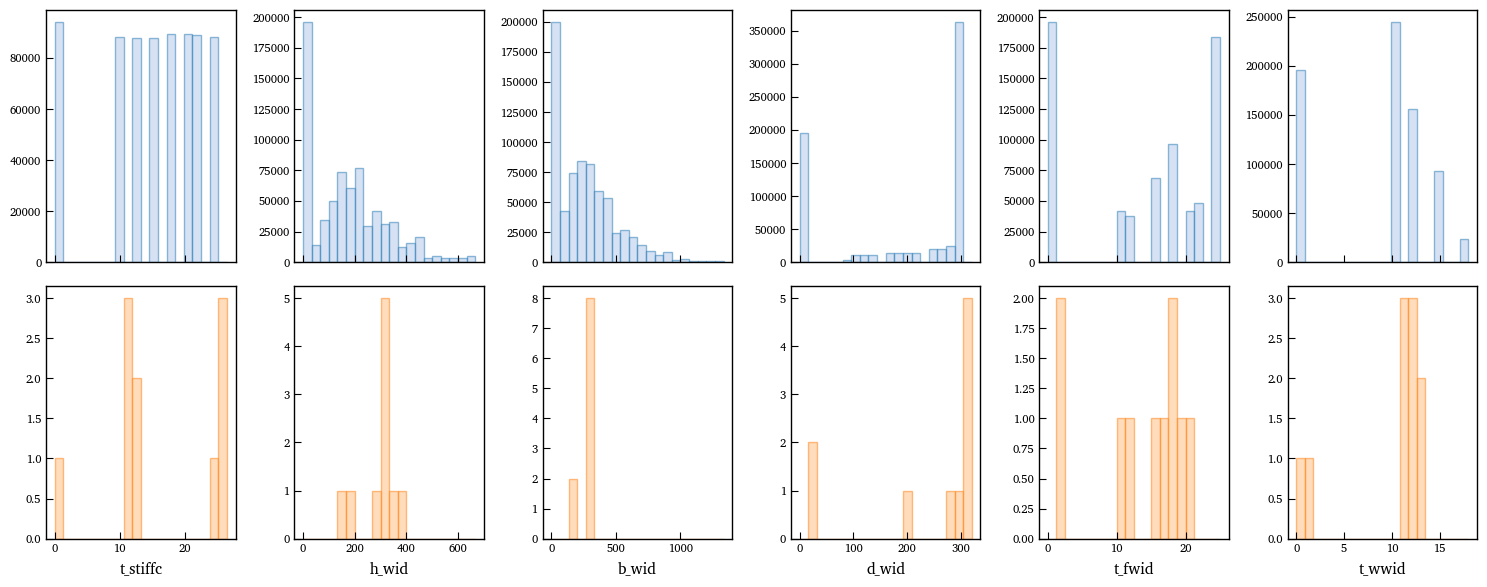

In [126]:
fig, axs = plt.subplots(2, len(variable_features[:-1]), figsize=(15, 6), sharex='col')

for i, feature in enumerate(variable_features[:-1]):
    all_values = np.concatenate([df_full[feature].values, df_samples[feature].values])
    bins = np.histogram_bin_edges(all_values, bins=20)

    ax = axs[0, i]
    ax.hist(df_full[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[0], 
            facecolor=plot_params.morecolors[1], 
            alpha=0.5)

    ax = axs[1, i]
    ax.hist(df_samples[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[2], 
            facecolor=plot_params.morecolors[3], 
            alpha=0.5)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

In [127]:
def snap_to_closest(df_samples, df_full, variable_features):
    for col in variable_features[:-1]:
        unique_values = df_full[col].unique()
        diffs = np.abs(df_samples[[col]].values - unique_values[None, :])
        closest_idx = diffs.argmin(axis=1)
        df_samples[col] = unique_values[closest_idx]

In [128]:
snap_to_closest(df_samples, df_full, variable_features[:-1])

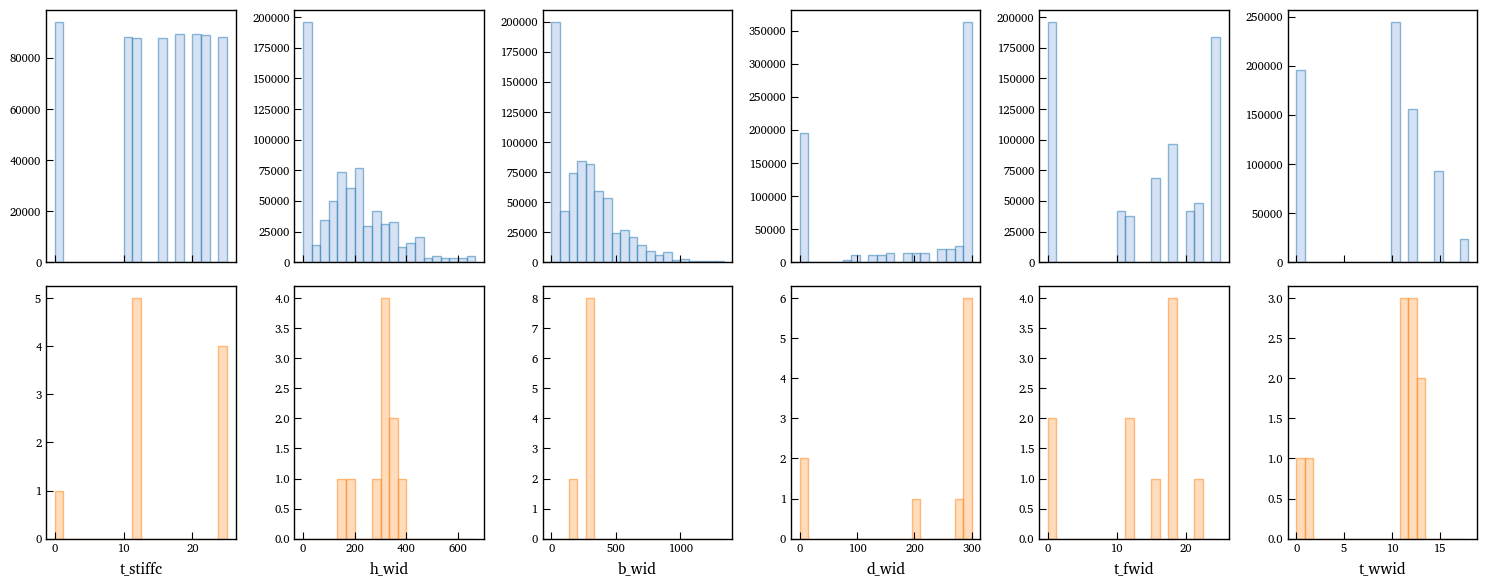

In [129]:
fig, axs = plt.subplots(2, len(variable_features[:-1]), figsize=(15, 6), sharex='col')

for i, feature in enumerate(variable_features[:-1]):
    all_values = np.concatenate([df_full[feature].values, df_samples[feature].values])
    bins = np.histogram_bin_edges(all_values, bins=20)

    ax = axs[0, i]
    ax.hist(df_full[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[0], 
            facecolor=plot_params.morecolors[1], 
            alpha=0.5)

    ax = axs[1, i]
    ax.hist(df_samples[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[2], 
            facecolor=plot_params.morecolors[3], 
            alpha=0.5)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

If one parameter of `widener` or `stiffener` equal to 0, set all to 0:

In [130]:
widener_features = ['h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid']

for i, sample in df_samples.iterrows():
    if np.any(sample[widener_features] ==0):
        for feature in widener_features:
            df_samples.at[i, feature] = 0.0

### Get IDEA Templates

In [131]:
idea_templates = []

for i,sample in df_samples.iterrows():
    idea_templates.append(get_ideatemplate(sample))

df_samples['ideatemplate'] = idea_templates

In [132]:
df_samples['ideatemplate'].value_counts()

ideatemplate
Corner_Stiff_Wid.ideaCon    8
Corner_Stiffner.ideaCon     1
Corner.ideaCon              1
Name: count, dtype: int64

### Get Loads

In [133]:
get_MV(df_samples)

In [134]:
df_samples

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_norm,target,Cat_h,Cat_t_stiffc,cost,Aw_x,Aw_y,r_x,r_y,ideatemplate
0,HEA340,330.0,300.0,9.5,16.5,13347.278956,4495.028956,276900000.0,3.790542e+05,1850000.0,...,NaN,NaN,NaN,NaN,NaN,2978.25,3325.00,27.0,27.0,Corner_Stiff_Wid.ideaCon
1,HEB320,320.0,300.0,11.5,20.5,16134.278956,5177.028956,308200000.0,2.773558e+06,2149000.0,...,NaN,NaN,NaN,NaN,NaN,3444.25,3091.00,27.0,27.0,Corner_Stiff_Wid.ideaCon
2,HEA400,390.0,300.0,11.0,19.0,15897.778956,5732.778956,450700000.0,2.148499e+06,2562000.0,...,NaN,NaN,NaN,NaN,NaN,4081.00,2978.25,27.0,27.0,Corner_Stiff_Wid.ideaCon
3,HEB180,180.0,180.0,8.5,14.0,6525.141653,2024.141653,38310000.0,1.080287e+06,481400.0,...,NaN,NaN,NaN,NaN,NaN,1411.00,1176.00,15.0,15.0,Corner_Stiff_Wid.ideaCon
4,HEA320,310.0,300.0,9.0,15.5,12436.778956,4113.278956,229300000.0,4.471084e+05,1628000.0,...,NaN,NaN,NaN,NaN,NaN,2650.50,3444.25,27.0,27.0,Corner_Stiff_Wid.ideaCon
5,HEA360,350.0,300.0,10.0,17.5,14275.778956,4895.778956,330900000.0,9.646685e+04,2088000.0,...,NaN,NaN,NaN,NaN,NaN,3325.00,3325.00,27.0,27.0,Corner_Stiff_Wid.ideaCon
6,HEA320,310.0,300.0,9.0,15.5,12436.778956,4113.278956,229300000.0,1.357819e+06,1628000.0,...,NaN,NaN,NaN,NaN,NaN,2650.50,3444.25,27.0,27.0,Corner_Stiff_Wid.ideaCon
7,HEA300,290.0,300.0,8.5,14.0,11252.778956,3727.778956,182600000.0,1.713414e+06,1383000.0,...,NaN,NaN,NaN,NaN,NaN,2346.00,2650.50,27.0,27.0,Corner_Stiff_Wid.ideaCon
8,HEA160,152.0,160.0,6.0,9.0,3877.141653,1321.141653,16730000.0,8.053140e+04,245100.0,...,NaN,NaN,NaN,NaN,NaN,858.00,896.00,15.0,12.0,Corner_Stiffner.ideaCon
9,HEB320,320.0,300.0,11.5,20.5,16134.278956,5177.028956,308200000.0,2.487095e+06,2149000.0,...,NaN,NaN,NaN,NaN,NaN,3444.25,4081.00,27.0,27.0,Corner.ideaCon


## OLD

### Define functions to estimate parameters

#### Estimate radius $r$


Given the normed data the width $b$ has been identified as the strongest correlation to the radius $r$, hence we fit a linear function, which estimates $f(b)=\hat{r}$.

In [ ]:
x = b
y = r

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

Slope: 0.08400521697889492, Intercept: 2.3215160856849337, R^2: 0.9502222132724109


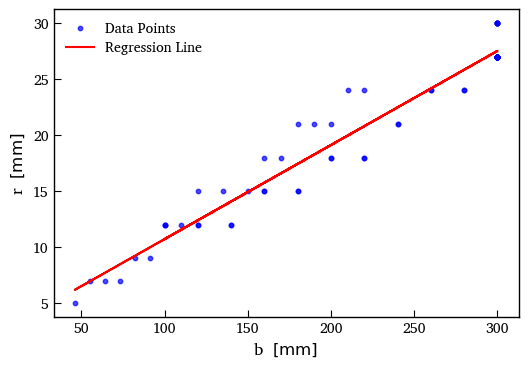

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(b,r, label='Data Points', color='blue', s=10, alpha=0.7)
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')

plt.ylabel(r"r  $\mathrm{[mm]}$")
plt.xlabel(r"b  $\mathrm{[mm]}$")

plt.legend()
plt.show()

In [108]:
r_func = lambda b: slope * b + intercept

#### Calculate $A_v$

$$A_v = A-2bt_f+(t_w+2r)t_f$$

In [109]:
Av_calc = df_full['A_x'] - 2 * df_full['b_x'] * df_full['tf_x'] + (df_full['tw_x'] + 2 * r_func(df_full['b_x'].values)) * df_full['tf_x']

Given the existing dataset, quantify the error of this method:

In [110]:
Av_calculation_error = df_full['Av_x'] / Av_calc

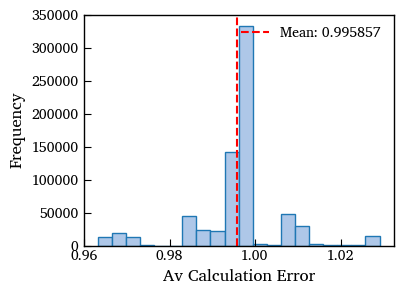

In [111]:
fig, ax = plt.subplots(figsize=(4,3))

plt.hist(Av_calculation_error, bins=20, 
         color=plot_params.morecolors[1], 
         edgecolor=plot_params.morecolors[0],)

plt.axvline(np.mean(Av_calculation_error), color='red', linestyle='--', label=f'Mean: {Av_calculation_error.mean():.6f}')

plt.xlabel('Av Calculation Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Calculate $A_w$

$$A_w = h\cdot t_w + 4\cdot\hat{r}$$

In [112]:
Aw = h * tw + c5['r'].values*4

### Fill in Data

In [ ]:
df_samples['r'] = r_func(df_samples['b_wid'].values)

In [ ]:
Ax_estimate = (df_samples['h_x']-df_samples['tf_x'])*df_samples['tw_x'] + (4*df_samples['r']**2 - df_samples['r']**2 * np.pi) + 2*df_samples['b_x']*df_samples['tf_x']

In [ ]:
Ay_estimate = (df_samples['h_x']-df_samples['tf_x']) * df_samples['tw_x'] + (4*df_samples['r']**2 - df_samples['r']**2 * np.pi) + 2*df_samples['b_x']*df_samples['tf_x']

In [ ]:
df_samples['A_x'] = Ax_estimate
df_samples['A_y'] = Ay_estimate

#### Calculate $\tau_y$

$$\tau_y=\frac{f_y}{\sqrt{3}}$$

In [ ]:
df_samples['tau _x'] = df_samples['fy_x'] / np.sqrt(3)
df_samples['tau _y'] = df_samples['fy_y'] / np.sqrt(3)

#### Calculate $A_v$

$$A_v=A - 2\cdot b_x \cdot t_f + (t_w + 2\cdot \hat{r})\cdot t_f$$

In [ ]:
df_samples['Av_x'] = df_samples['A_x'] - 2 * df_samples['b_x'] * df_samples['tf_x'] + (df_samples['tw_x'] + 2 * r_func(df_samples['b_x'].values)) * df_samples['tf_x'] 

#### Calculate $V_{pl}$ & $M_{pl}$

In [ ]:
df_samples['Mpl_x'] = df_samples['Wply_x'] * df_samples['fy_x'] / 1000000
df_samples['Vpl_x'] = df_samples['Av_x'] * df_samples['tau_x'] / 1000
df_samples['Mpl_y'] = df_samples['Wply_y'] * df_samples['fy_y'] / 1000000
df_samples['Vpl_y'] = df_samples['Av_y'] * df_samples['tau_y'] / 1000

#### Estimate $M$ & $V$

In [ ]:
get_MV(df_samples)

## Data Generation

### Generate

In [ ]:
print(f"Number of samples to generate: {len(df_samples)}")

for idea_template in df_samples['ideatemplate'].unique():
    df_to_add = df_samples[df_samples['ideatemplate'] == idea_template]

    print(f"Adding {len(df_to_add)} samples with template {idea_template}...")

    IdeaName = os.path.join(PATH,idea_template)

    conn = IdeaConnectionClient()
    conn.open(IdeaName)

    for progress,profile_id in enumerate(list(df_to_add.index)):
        print(f"Progress: {progress / len(df_to_add) * 100:.2f}%")

        params = {
            'Prof_c': df_samples.at[profile_id, 'Profile_x'], 'Prof_b': df_samples.at[profile_id, 'Profile_y'],
            'steel_grade': df_samples.at[profile_id, 'Steel grade_x'], 'gamma': df_samples.at[profile_id, 'Gamma'],
            'h_wid': df_samples.at[profile_id, 'h_wid']/1000, 'b_wid': df_samples.at[profile_id, 'b_wid']/1000,
            'd_wid': df_samples.at[profile_id, 'd_wid']/1000, 't_fwid': df_samples.at[profile_id, 't_fwid']/1000,
            't_wwid': df_samples.at[profile_id, 't_wwid']/1000,
            't_stiffc': df_samples.at[profile_id, 't_stiffc']/1000, 't_stiffb': df_samples.at[profile_id, 't_stiffb']/1000,
            'offset': df_samples.at[profile_id, 'Offset']/1000
        }

        print('      Set Load in Idea')

        conn.update_params_by_name(params)
        if not conn.params_valid():
            raise Exception("Parameters validation failed.")
        
        loads = conn.get_loads()

        loads[0]['forcesOnSegments'][1]['my'] = int(df_samples.at[profile_id,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(df_samples.at[profile_id,'V']*1000)#!!!!

        conn.set_loads(loads) 
        print('      M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('      V=',loads[0]['forcesOnSegments'][1]['qz'] )           

        print('      Calculate...') 
        start_time = time.time()
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,conn,df_samples,profile_id)
        end_time = time.time()

        if calculated == False:
            print(f"Calculation failed for profile {profile_id}.")
            continue

        df_samples.at[profile_id, 'calculation_time'] = end_time - start_time

        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
        if applied_percentage == 1.0:
            results, loads, applied_percentage = underloaded(applied_percentage,df_samples,profile_id)

        applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
        applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

        df_samples.at[profile_id, 'proz'] = applied_percentage
        df_samples.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
        df_samples.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

        cost = results['costEstimationResults']['totalEstimatedCost']
        df_samples.at[profile_id, 'cost'] = cost

    print('   Close Idea')
    conn.close()

calculate_target_from_Rd(df_samples)

Number of samples to generate: 10
Adding 8 samples with template Corner_Stiff_Wid.ideaCon...
c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiff_Wid.ideaCon
Progress: 0.00%
      Set Load in Idea
      M= 803947
      V= 451142
      Calculate...
Progress: 12.50%
      Set Load in Idea
      M= 538236
      V= 794665
      Calculate...
Progress: 25.00%
      Set Load in Idea
      M= 552877
      V= 775737
      Calculate...
Progress: 37.50%
      Set Load in Idea
      M= 0
      V= 1490522
      Calculate...
k = 0
M= 0
V= 1341470
k = 1
M= 0
V= 1207323
Calculation failed for profile 3.
Progress: 50.00%
      Set Load in Idea
      M= 0
      V= 1490522
      Calculate...
Progress: 62.50%
      Set Load in Idea
      M= 326753
      V= 1068080
      Calculate...
Progress: 75.00%
      Set Load in Idea
      M= 797460
      V= 459528
      Calculate...
Progress: 87.50%
      Set Load in Idea
      M= 541486
      V= 790463
      Calculate...
   Close

In [136]:
df_samples.to_csv(os.path.join(directory.root, r'Data\GAL_Generated_Data.csv'), index=False)

### Load

In [82]:
df_samples = pd.read_csv(os.path.join(directory.root, r'Data\GAL_Generated_Data.csv'))

### Analyse

In [ ]:
sample = df_samples.iloc[1:2]
M_Rd_pred, V_Rd_pred, _ = model.get_MV_interaction_prediction(sample, n_predictions=20)

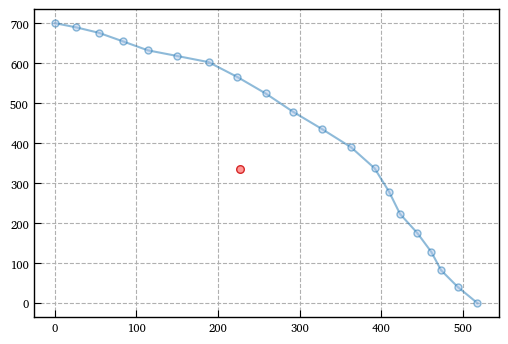

In [141]:
plt.plot(M_Rd_pred, V_Rd_pred,
            label='Predicted Interaction',
            marker='o',
            c=plot_params.morecolors[0],
            markerfacecolor=plot_params.morecolors[1],
            markeredgecolor=plot_params.morecolors[0],
            alpha=0.5,
            markersize=5)

plt.scatter(sample['M_Rd'].values, sample['V_Rd'].values,
            label='Added Data',
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            alpha=1.0,
            s=30)

plt.grid(True, linestyle='--', zorder=0)

In [143]:
with open(os.path.join(directory.root,r'Saved Variables\RF_calculation_validation.pkl'), 'rb') as f:
    forest = pickle.load(f)

In [ ]:
template_mapping = {
    get_ideatemplate(df_full[(df_full['Cat_h']==0) & (df_full['Cat_t_stiffc']==0)].iloc[0:1]): (0,0),
    get_ideatemplate(df_full[(df_full['Cat_h']==1) & (df_full['Cat_t_stiffc']==1)].iloc[0:1]): (1,0),
    get_ideatemplate(df_full[(df_full['Cat_h']==0) & (df_full['Cat_t_stiffc']==1)].iloc[0:1]): (0,1),
}

for template, (Cat_h, Cat_t_stiffc) in template_mapping.items():
    df_samples.loc[df_samples['ideatemplate'] == template, 'Cat_h'] = True if Cat_h == 1 else False
    df_samples.loc[df_samples['ideatemplate'] == template, 'Cat_t_stiffc'] = True if Cat_t_stiffc == 1 else False

In [ ]:
forest_features = model.features.copy()
forest_features.append('Cat_h')
forest_features.append('Cat_t_stiffc')

X = df_samples[forest_features].select_dtypes(include='number').copy()
X['Cat_h'] = df_samples['Cat_h'].astype(int)
X['Cat_t_stiffc'] = df_samples['Cat_t_stiffc'].astype(int)

y_pred = forest.predict(X)

In [262]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Analyse Results

In [10]:
df_samples = pd.read_csv(os.path.join(directory.root, r'Data\GAL_Generated_Data.csv'))

In [36]:
df_samples_filtered = df_samples[~np.isnan(df_samples['M_Rd'].values)].copy()

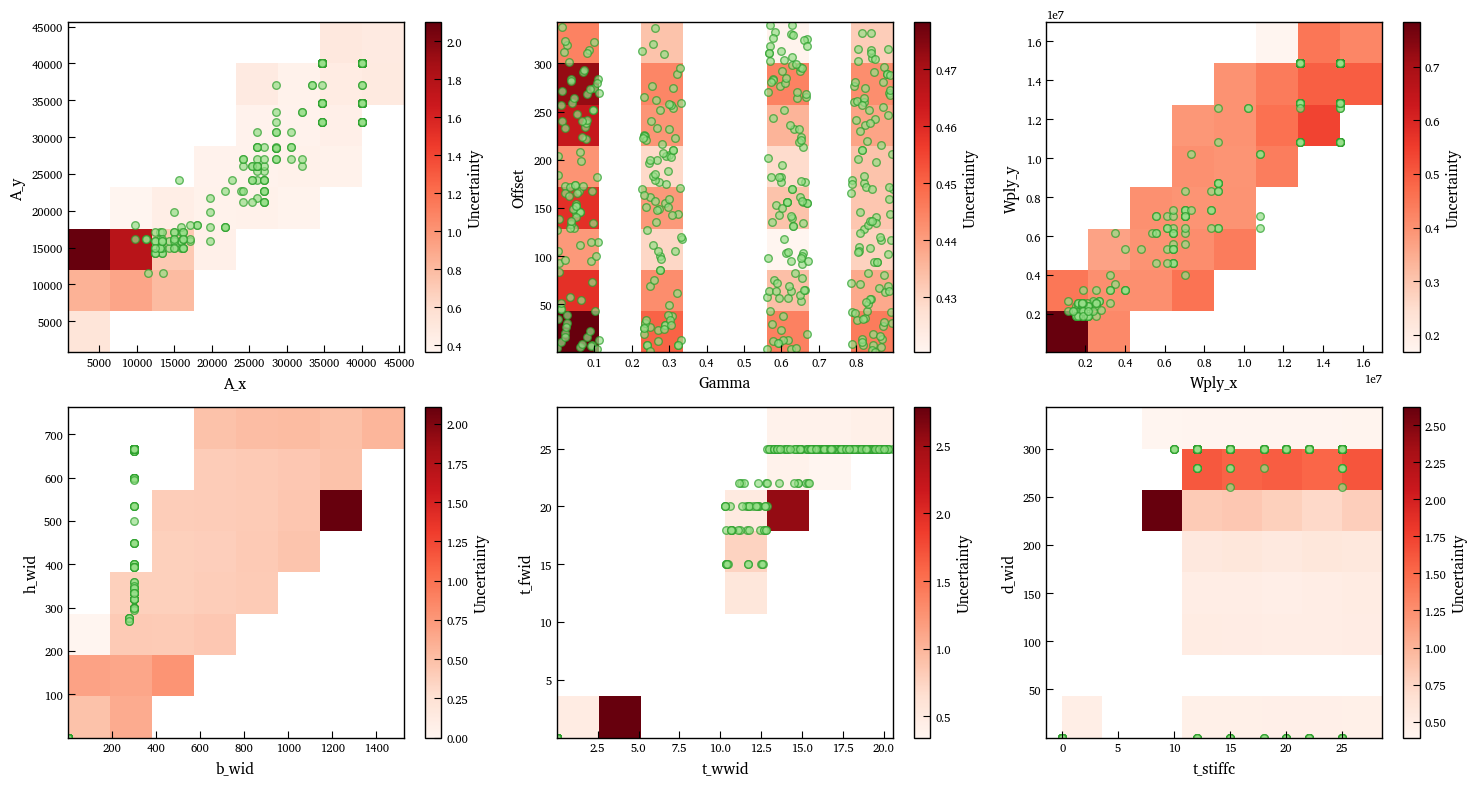

In [77]:
grid_x, grid_y = m+1, m+1

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i,(x_feature,y_feature) in enumerate(zip(['A_x','Gamma','Wply_x','b_wid','t_wwid','t_stiffc'],['A_y','Offset','Wply_y','h_wid','t_fwid','d_wid'])):
    
    x = df_hypercube_samples[x_feature].values
    y = df_hypercube_samples[y_feature].values
    c = np.clip(uncertainty_hypercube, 0, None).flatten()

    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, c, statistic='median', bins=[grid_x, grid_y]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, 
                    (y_edges[:-1] + y_edges[1:]) / 2)

    pcm = axs[int(i/3),i%3].pcolormesh(X, Y, stat.T, cmap='Reds', shading='auto')

    axs[int(i/3),i%3].scatter(df_samples_filtered[x_feature].values, df_samples_filtered[y_feature].values,
                              facecolor=plot_params.morecolors[5],
                              edgecolor=plot_params.morecolors[4], 
                              s=30, alpha=0.7)

    fig.colorbar(pcm, ax=axs[int(i/3),i%3], label="Uncertainty")

    axs[int(i/3),i%3].set_xlabel(x_feature)
    axs[int(i/3),i%3].set_ylabel(y_feature)

plt.tight_layout()
plt.show()

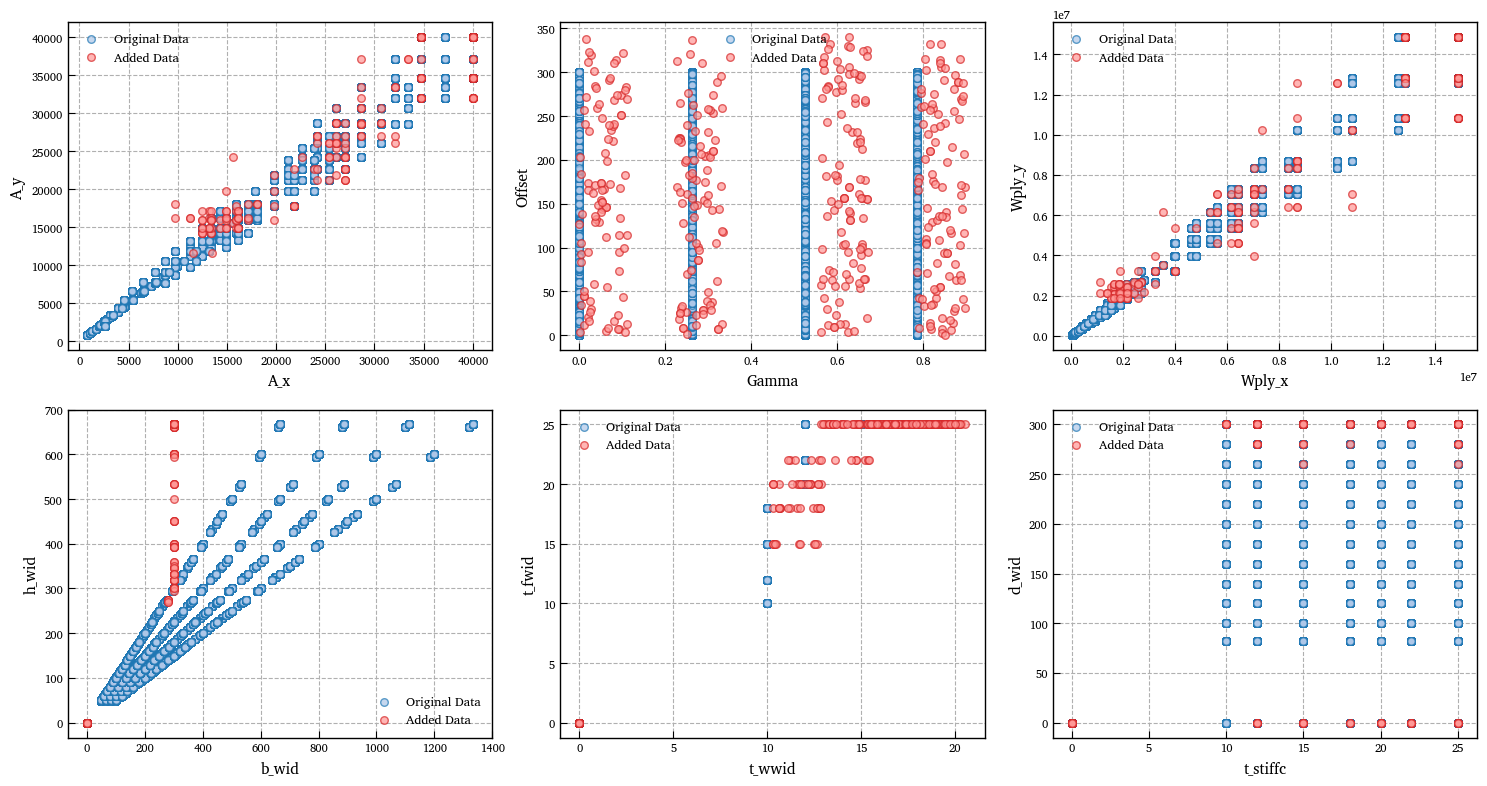

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i,(x_feature,y_feature) in enumerate(zip(['A_x','Gamma','Wply_x','b_wid','t_wwid','t_stiffc'],['A_y','Offset','Wply_y','h_wid','t_fwid','d_wid'])):
    
    ax = axs[int(i/3),i%3]

    ax.scatter(df_full[x_feature].values, df_full[y_feature].values,
               facecolor=plot_params.morecolors[1],
               edgecolor=plot_params.morecolors[0], 
               s=30, alpha=0.7, label='Original Data',
               zorder=2)
    
    ax.scatter(df_samples_filtered[x_feature].values, df_samples_filtered[y_feature].values,
               facecolor=plot_params.morecolors[7],
               edgecolor=plot_params.morecolors[6], 
               s=30, alpha=0.7, label='Added Data',
               zorder=2)
    
    ax.grid(True, linestyle='--', zorder=0)

    ax.legend()
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)

plt.tight_layout()
plt.show()

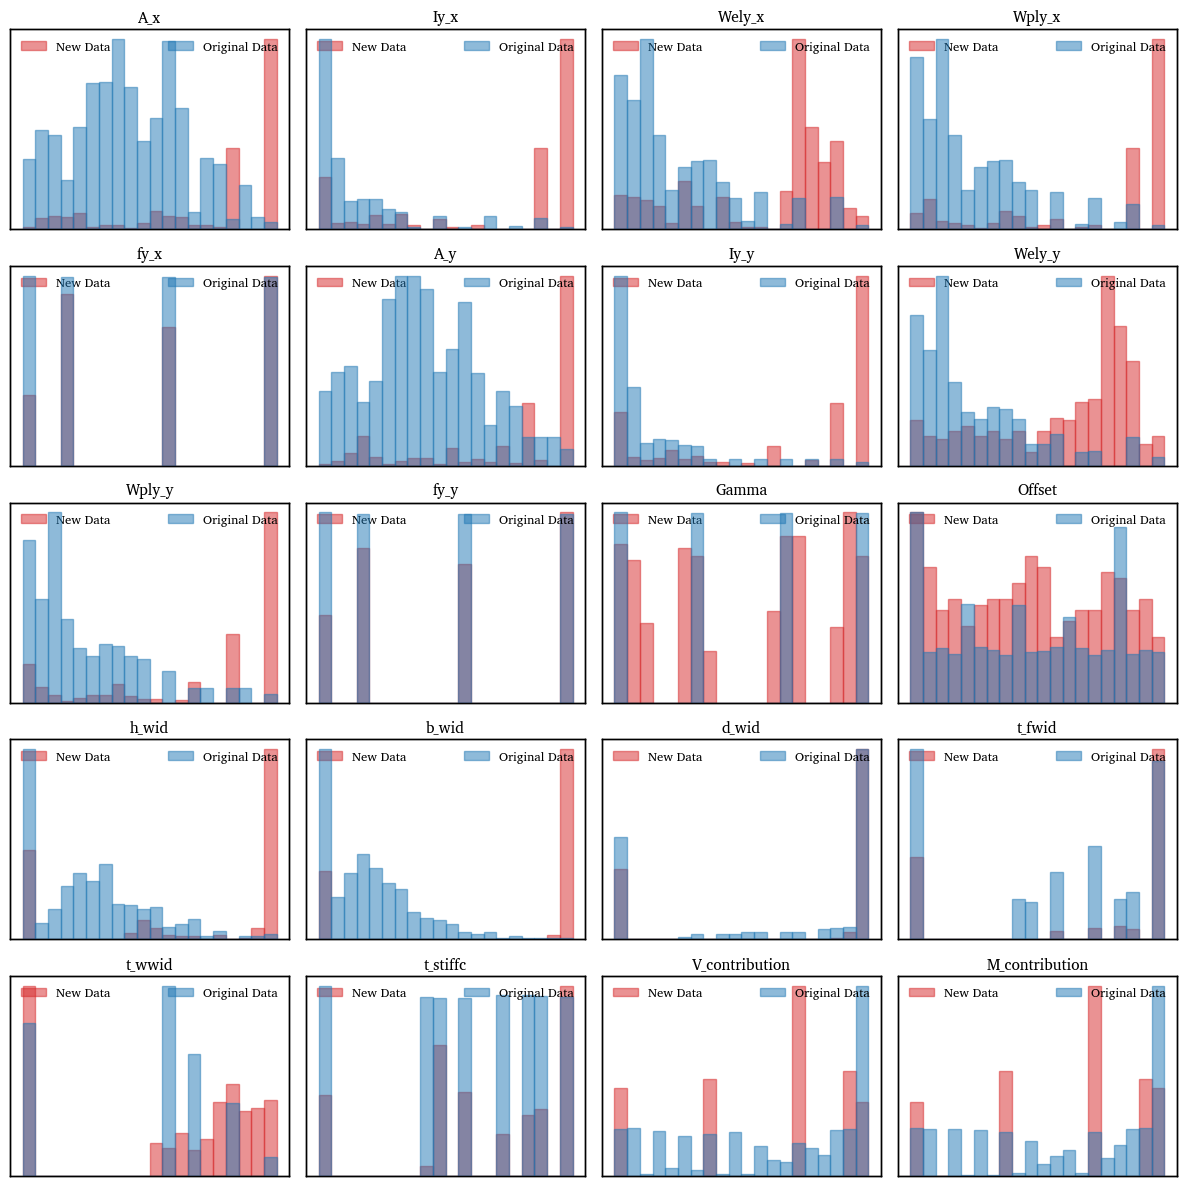

In [80]:
fig, axs = plt.subplots(int(len(model.features)/4), 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    normed_added_data = (df_samples_filtered[feature].values - df_samples_filtered[feature].min()) / (df_samples_filtered[feature].max() - df_samples_filtered[feature].min())
    normed_full_data = (df_full[feature].values - df_full[feature].min()) / (df_full[feature].max() - df_full[feature].min())

    ax.hist(normed_added_data, bins=20, 
            edgecolor=plot_params.colors[3], 
            facecolor=plot_params.colors[3],
            alpha=0.5, label='New Data')
    ax2.hist(normed_full_data, bins=20, 
             edgecolor=plot_params.colors[0],
             facecolor=plot_params.colors[0],
             alpha=0.5, label='Original Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
